# Understanding RAG Systems: A Hands-On Tutorial

## Welcome!

In this notebook, you'll learn about **Retrieval-Augmented Generation (RAG)** systems by building one from scratch.

### What is RAG?

RAG is a technique that enhances Large Language Models (LLMs) by providing them with relevant information retrieved from a document collection. Instead of relying solely on the model's training data, RAG allows the model to access specific, up-to-date information to generate more accurate and grounded responses.

### Why is RAG Important?

- **Reduces hallucinations**: Grounds responses in actual documents
- **Enables domain-specific knowledge**: Works with proprietary or specialized information
- **Stays current**: No need to retrain models with new information
- **Transparency**: You can see which documents informed the response

### What You'll Build

A complete RAG pipeline including:
1. Document ingestion and chunking
2. Embedding generation
3. Similarity-based retrieval
4. Visualization of embedding spaces
5. Prompt construction for LLMs

**Estimated time**: 60-90 minutes  
**Prerequisites**: Basic Python knowledge

Let's get started!

---
## Section 0: Setup & Dependencies

Before we begin, we need to install and import the required libraries.

### Required Libraries:

- **pandas**: Data manipulation and storage in DataFrames
- **numpy**: Numerical operations and array handling
- **matplotlib**: 2D plotting and visualization
- **seaborn**: Statistical visualizations (especially heatmaps)
- **plotly**: Interactive 3D visualizations
- **sentence-transformers**: Pre-trained embedding models
- **umap-learn**: Dimensionality reduction for visualization
- **ipywidgets** (optional): Interactive controls and sliders
- **tqdm**: Progress bars for long-running operations
- **scikit-learn**: Machine learning utilities

### Installation

Run the cell below to install all dependencies:

In [ ]:
# Install all required packages
# Note: This may take a few minutes on first run

# !pip install pandas numpy matplotlib seaborn plotly sentence-transformers umap-learn ipywidgets tqdm scikit-learn

### Import Libraries and Verify Installation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sentence_transformers import SentenceTransformer, util
import umap
from tqdm.auto import tqdm
import warnings
import torch
import os
# Disable parallelism for tokenizers to avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Optional: ipywidgets for interactive controls
try:
    from ipywidgets import interact, widgets
    WIDGETS_AVAILABLE = True
    print("✓ ipywidgets available - interactive controls enabled")
except ImportError:
    WIDGETS_AVAILABLE = False
    print("⚠ ipywidgets not available - using simple variables instead")

# Configure display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Print versions
print("\n=== Package Versions ===")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")

# Check for GPU availability
if torch.cuda.is_available():
    print(f"\n✓ GPU available: {torch.cuda.get_device_name(0)}")
    print("  Embedding generation will be faster!")
else:
    print("\n⚠ No GPU detected - using CPU (embeddings will be slower)")

print("\n✓ All imports successful! Ready to proceed.")

✓ ipywidgets available - interactive controls enabled

=== Package Versions ===
pandas: 2.3.3
numpy: 2.3.4

⚠ No GPU detected - using CPU (embeddings will be slower)

✓ All imports successful! Ready to proceed.


### Expected Runtime Notes

**Embedding Generation:**
- With GPU: ~30-60 seconds for 100 chunks
- With CPU: ~2-5 minutes for 100 chunks

**Memory Requirements:**
- Minimum: 2GB RAM
- Recommended: 4GB+ RAM for smooth UMAP visualization

**Troubleshooting:**
- If imports fail, restart the kernel and re-run the installation cell
- If you get memory errors during UMAP, reduce the number of chunks displayed
- For slower computers, consider using the smaller embedding model (all-MiniLM-L6-v2)

---
## Configuration Section

Let's configure the key parameters for our RAG system.

### Embedding Model Selection

We'll use models from the `sentence-transformers` library. These models convert text into dense vector representations (embeddings) that capture semantic meaning.

**Available Models:**

1. **all-MiniLM-L6-v2** (Default)
   - Dimensions: 384
   - Speed: Fast
   - Quality: Good for most tasks
   - Best for: Learning and experimentation

2. **all-mpnet-base-v2** (Higher Quality)
   - Dimensions: 768
   - Speed: Slower (2-3x)
   - Quality: Better semantic understanding
   - Best for: Production-quality results

Choose your model below:

In [3]:
# MODEL CONFIGURATION
# Change this to switch between models
MODEL_NAME = "all-MiniLM-L6-v2"  # Options: "all-MiniLM-L6-v2" or "all-mpnet-base-v2"

# Load the model
print(f"Loading model: {MODEL_NAME}...")
model = SentenceTransformer(MODEL_NAME)

# Display model information
embedding_dim = model.get_sentence_embedding_dimension()
print(f"\n✓ Model loaded successfully!")
print(f"  Embedding dimensions: {embedding_dim}")
print(f"  Max sequence length: {model.max_seq_length} tokens")

if MODEL_NAME == "all-MiniLM-L6-v2":
    print("\n💡 Tip: For better quality (but slower speed), try 'all-mpnet-base-v2'")
else:
    print("\n💡 You're using the higher-quality model - embeddings will be more accurate!")

Loading model: all-MiniLM-L6-v2...

✓ Model loaded successfully!
  Embedding dimensions: 384
  Max sequence length: 256 tokens

💡 Tip: For better quality (but slower speed), try 'all-mpnet-base-v2'


---
## Section 1: Document Ingestion

In this section, we'll load sample documents from three different domains. This diversity will help you understand how RAG systems work across different types of content.

### Available Documents:

1. **Economic Context**: Discusses economic theories, market mechanisms, and fiscal policy
2. **Literary Context**: Explores literary analysis, movements, and narrative techniques  
3. **Philosophy Context**: Examines philosophical arguments, ethics, and epistemology

Each document is substantial enough to create approximately 100 chunks, giving us a realistic dataset to work with.

In [4]:
# Sample Documents - Each approximately 20,000+ characters

ECONOMIC_DOC = """The study of economics is fundamentally concerned with how societies allocate scarce resources among competing uses. This allocation problem arises because human wants are virtually unlimited, while the resources available to satisfy these wants are finite. Understanding this basic economic problem is essential to grasping more complex economic concepts and phenomena.

Microeconomics focuses on the behavior of individual economic agents, such as consumers, firms, and workers. It examines how these agents make decisions about the allocation of resources and how these decisions interact in markets. The concept of supply and demand is central to microeconomic analysis. Supply represents the quantity of a good or service that producers are willing to sell at various prices, while demand represents the quantity that consumers are willing to buy. The intersection of supply and demand curves determines the equilibrium price and quantity in a market.

Consumer behavior is analyzed through the lens of utility theory, which posits that consumers seek to maximize their satisfaction or utility subject to their budget constraints. This framework helps explain how consumers make choices among different goods and services. The law of diminishing marginal utility suggests that as consumption of a good increases, the additional satisfaction from consuming one more unit decreases. This principle has important implications for understanding demand curves and consumer choices.

On the production side, firms operate to maximize profits by choosing the optimal combination of inputs to produce outputs. Production functions describe the relationship between inputs like labor and capital and the resulting output. Firms face various cost structures, including fixed costs that don't vary with production levels and variable costs that do. Understanding these cost structures is crucial for analyzing firm behavior and market outcomes.

Market structures vary significantly, from perfect competition to monopoly, with oligopoly and monopolistic competition in between. In perfectly competitive markets, numerous small firms produce identical products, and no single firm can influence the market price. Monopolies, conversely, feature a single seller with significant market power to set prices. These different market structures lead to different outcomes in terms of prices, quantities, and economic efficiency.

Macroeconomics takes a broader view, examining the economy as a whole. It focuses on aggregate variables such as gross domestic product (GDP), unemployment rates, and inflation. GDP measures the total value of all goods and services produced in an economy during a specific period. It serves as a comprehensive scorecard of economic health and is used to compare economic performance across time and between countries.

Economic growth, the increase in an economy's productive capacity over time, is a central concern of macroeconomics. Various theories attempt to explain what drives economic growth. Classical growth theory emphasizes capital accumulation and technological progress. The Solow growth model demonstrates that in the long run, per capita income growth depends primarily on technological advancement rather than capital accumulation. Endogenous growth theory goes further, suggesting that technological progress itself results from economic activities and policy choices.

Unemployment represents one of the most visible economic problems. Economists distinguish between several types of unemployment: frictional unemployment resulting from the time it takes workers to find new jobs, structural unemployment caused by mismatches between workers' skills and job requirements, and cyclical unemployment that rises and falls with the business cycle. The natural rate of unemployment includes frictional and structural unemployment but not cyclical unemployment.

Inflation, the general increase in price levels over time, erodes purchasing power and can create economic uncertainty. Moderate inflation is often seen as normal in a growing economy, but high inflation can be destructive. Deflation, or falling prices, can also be problematic as it may lead consumers and businesses to delay purchases, potentially causing economic slowdowns. Central banks typically target a low, positive inflation rate as part of their monetary policy objectives.

Fiscal policy involves government decisions about taxation and spending. Governments can use expansionary fiscal policy, increasing spending or cutting taxes, to stimulate economic activity during recessions. Conversely, contractionary fiscal policy, reducing spending or raising taxes, can help cool an overheating economy. However, fiscal policy faces several challenges, including recognition lags in identifying economic problems, implementation lags in enacting policy changes, and impact lags before policies affect the economy.

Monetary policy, conducted by central banks, involves managing the money supply and interest rates to achieve macroeconomic objectives. Central banks can increase the money supply through various mechanisms, including lowering interest rates, which encourages borrowing and spending. The Federal Reserve in the United States uses tools like open market operations, the discount rate, and reserve requirements to implement monetary policy. The effectiveness of monetary policy depends on various factors, including the transmission mechanism through which policy changes affect the real economy.

International trade allows countries to specialize in producing goods and services where they have comparative advantages. The theory of comparative advantage, developed by David Ricardo, demonstrates that trade can benefit all participating countries, even if one country is more efficient at producing everything. Trade agreements aim to reduce barriers like tariffs and quotas, facilitating greater international commerce. However, trade can create winners and losers within countries, leading to political debates about trade policy.

Exchange rates, the prices at which currencies trade, play a crucial role in international economics. Floating exchange rates are determined by supply and demand in foreign exchange markets, while fixed exchange rates are maintained by government interventions. Exchange rate movements affect international competitiveness, as a stronger currency makes exports more expensive and imports cheaper. Countries sometimes manipulate their exchange rates to gain trade advantages, though such practices are controversial.

Financial markets facilitate the flow of funds from savers to borrowers, playing a vital role in economic efficiency. Stock markets allow companies to raise capital by selling ownership shares, while bond markets enable borrowing through debt instruments. Financial intermediaries like banks transform short-term deposits into long-term loans, providing liquidity and risk management services. Financial market efficiency depends on information availability and the absence of distortions.

Market failures occur when free markets fail to allocate resources efficiently. Externalities, costs or benefits affecting third parties not involved in transactions, represent one type of market failure. Pollution is a classic negative externality, as producers don't bear the full cost of environmental damage. Public goods, which are non-excludable and non-rivalrous, create another market failure as private markets tend to underproduce them. Government intervention through regulation, taxes, subsidies, or direct provision often aims to correct market failures.

Income inequality has emerged as a major economic and social concern. The Gini coefficient measures inequality, with values ranging from zero (perfect equality) to one (complete inequality). Various factors contribute to inequality, including differences in education, skills, inheritance, and luck. Technological change and globalization may have increased inequality by disproportionately benefiting those with higher skills and education. Policies to address inequality include progressive taxation, education investments, and social safety nets.

Behavioral economics challenges the traditional assumption of perfectly rational economic agents. Research shows that people often make systematic errors in judgment and decision-making, influenced by psychological biases and heuristics. Loss aversion, the tendency to feel losses more intensely than equivalent gains, affects economic choices. Present bias leads people to overvalue immediate rewards relative to future benefits, explaining phenomena like inadequate retirement savings. Understanding these behavioral patterns can inform policy design, such as using defaults to encourage better savings decisions.

Economic development focuses on improving living standards in lower-income countries. Development economics examines factors that promote or hinder economic growth in these contexts. Institutional quality, including property rights, rule of law, and government effectiveness, significantly impacts development outcomes. Access to education, healthcare, and infrastructure also plays crucial roles. Foreign aid, trade policy, and technology transfer are policy tools used to promote development, though their effectiveness remains debated.

Environmental economics addresses the interaction between economic activity and environmental quality. Climate change represents a massive negative externality, as greenhouse gas emissions impose costs globally but aren't fully reflected in market prices. Carbon pricing through taxes or cap-and-trade systems aims to internalize these externalities. Sustainable development seeks to meet present needs without compromising future generations' ability to meet their needs, requiring careful balance between economic growth and environmental protection."""

LITERARY_DOC = """Literature, as an art form, encompasses the written works that express ideas, emotions, and stories through carefully crafted language. The study of literature involves analyzing how authors use various literary devices and techniques to create meaning, evoke responses, and explore the human condition. Understanding literature requires attention to both form and content, examining not just what authors say but how they say it.

Literary movements represent distinct periods and styles in literary history, each characterized by particular themes, techniques, and philosophical outlooks. Romanticism, which flourished in the late 18th and early 19th centuries, emphasized emotion, imagination, and individual experience. Romantic writers celebrated nature, valued spontaneity over artifice, and often explored the relationship between humanity and the natural world. They rejected the Enlightenment's emphasis on reason alone, instead embracing feeling and intuition as equally valid ways of understanding reality.

Realism emerged in the mid-19th century as a reaction against Romanticism's idealization. Realist writers sought to depict life as it actually was, focusing on ordinary people and everyday situations. They employed detailed, objective descriptions and avoided melodrama or sentimentality. Social and economic conditions often featured prominently in realist works, which examined how external circumstances shaped individual lives. Authors like Gustave Flaubert and George Eliot exemplified realist principles in their novels.

Modernism, developing in the late 19th and early 20th centuries, represented a radical break with traditional literary forms and conventions. Modernist writers experimented with narrative structure, often fragmenting chronology and employing stream-of-consciousness techniques to represent inner mental states. They questioned traditional values and certainties, reflecting the upheavals of their era including industrialization, urbanization, and world wars. Works by James Joyce, Virginia Woolf, and T.S. Eliot exemplify modernist innovation.

Narrative technique encompasses the methods authors use to tell stories. Point of view determines the perspective from which a story is told. First-person narration uses I and provides direct access to one character's thoughts and perceptions, creating intimacy but limiting perspective. Third-person narration uses he or she and can be either limited, focusing on one character's perspective, or omniscient, providing access to multiple characters' thoughts and knowledge beyond any single character's awareness.

Characterization involves the methods by which authors create and develop characters. Direct characterization explicitly tells readers about a character's traits, while indirect characterization shows character through actions, dialogue, thoughts, and others' reactions. Complex characters exhibit multiple, sometimes contradictory traits and undergo development throughout the narrative. Flat characters, conversely, embody one or two traits and remain relatively unchanged. The choice between these approaches depends on the character's role in the narrative.

Plot structure typically follows a pattern of exposition, rising action, climax, falling action, and resolution. Exposition introduces characters, setting, and initial situation. Rising action builds tension through complications and conflicts. The climax represents the point of highest tension or the turning point. Falling action deals with consequences of the climax, and resolution provides closure. However, many modern and postmodern works deliberately subvert this traditional structure, leaving conflicts unresolved or presenting events in non-chronological order.

Setting encompasses both the physical location and temporal period in which events occur. Settings can be realistic or imaginary, detailed or vague, depending on the author's purposes. Setting often does more than provide backdrop; it can influence character behavior, symbolize themes, create mood, or serve as an active force in the narrative. Gothic literature, for instance, uses ominous settings to generate atmosphere and psychological tension.

Symbolism involves using objects, characters, or events to represent abstract ideas or concepts beyond their literal meaning. Symbols can be universal, like darkness representing ignorance or evil, or contextual, deriving meaning from their specific use within a work. Authors develop symbols through repetition, positioning, and association. Effective symbolism enriches texts with layers of meaning without being heavy-handed or obvious.

Theme represents the underlying meaning or central idea of a literary work. Unlike plot, which concerns what happens, theme addresses what the work means or what it says about the human experience. A single work can explore multiple themes. Common themes include the individual versus society, the loss of innocence, the nature of good and evil, and the search for identity. Themes emerge through the accumulation of details, events, and patterns rather than through direct statement.

Imagery uses descriptive language to create sensory experiences for readers. Visual imagery describes what characters see, but effective imagery engages all senses: sound, smell, taste, and touch. Vivid imagery helps readers visualize scenes, understand characters' experiences, and engage emotionally with texts. Patterns of imagery can reinforce themes; for example, repeated references to confinement might underscore themes of imprisonment or restriction.

Tone reflects the author's attitude toward the subject matter or audience. Tone can be serious, ironic, humorous, melancholic, or adopt many other qualities. Authors create tone through word choice, sentence structure, and the selection of details. Tone differs from mood, which refers to the emotional atmosphere experienced by readers. The same event described in different tones creates vastly different effects.

Irony involves a discrepancy between expectation and reality. Verbal irony occurs when words convey meaning opposite to their literal sense, often overlapping with sarcasm. Situational irony involves events that contradict expectations or seem incongruous. Dramatic irony occurs when readers know something characters don't, creating tension or humor. Irony adds complexity and can create subtle criticism or commentary.

Poetry employs concentrated, musical language to create effects and meanings. Poetic devices include metaphor and simile, which create comparisons; personification, which attributes human characteristics to non-human things; and alliteration, which repeats initial consonant sounds. Rhythm and meter create patterns of stressed and unstressed syllables. Rhyme can occur at line ends or internally. Free verse abandons regular meter and rhyme but still employs other poetic devices.

Dramatic literature, written for performance, presents special considerations. Dialogue reveals character and advances plot without narrative exposition. Stage directions indicate actions, entrances, exits, and sometimes tone or manner of speech. Dramatic structure often follows a five-act pattern: exposition, rising action, climax, falling action, and denouement. However, modern drama frequently experiments with structure, breaking fourth walls or rejecting traditional narrative progression.

Literary criticism encompasses various approaches to analyzing and interpreting literature. Formalist criticism focuses on the text itself, examining how literary devices create meaning and effect. Historical criticism considers works in their historical contexts, exploring how social, political, and cultural factors influence creation and reception. Psychological criticism applies psychological theories to understand characters, authors, or readers.

Feminist literary criticism examines how literature represents women, gender roles, and power dynamics. It questions how canonical literature has excluded or marginalized women's voices and experiences. Feminist critics analyze how texts construct femininity and masculinity, often revealing underlying patriarchal assumptions. This approach has expanded literary canons and transformed understanding of many traditional works.

Postcolonial criticism addresses literature's relationship to colonialism and imperialism. It examines how colonial powers represented colonized peoples and how postcolonial writers respond to and resist these representations. Postcolonial critics analyze themes of identity, hybridity, and cultural conflict. They explore how colonized peoples have used literature to assert their voices, reclaim histories, and challenge dominant narratives.

Intertextuality refers to connections between texts, how works reference, echo, or respond to other works. These connections can be explicit, through direct quotation or allusion, or implicit, through shared themes, structures, or styles. Understanding intertextuality enriches interpretation by revealing how texts participate in ongoing literary conversations. T.S. Eliot's poetry, densely packed with allusions, exemplifies conscious intertextuality.

Genre classification groups works by shared characteristics, conventions, and expectations. Major genres include fiction, poetry, and drama, each with numerous subgenres. Genre conventions guide both creation and reception, establishing frameworks readers use to understand works. However, many significant works transcend or deliberately violate genre boundaries, creating hybrid forms or challenging readers' expectations.

The canon, the body of works considered most significant or worthy of study, has been continuously debated and revised. Traditional canons often privileged works by white male authors from Western Europe and North America. Recent decades have seen expansion to include works by women, people of color, non-Western authors, and representatives of previously marginalized groups. These changes reflect evolving understanding of literature's purposes and values."""

PHILOSOPHY_DOC = """Philosophy, derived from the Greek words for love and wisdom, represents humanity's systematic attempt to understand fundamental questions about existence, knowledge, values, reason, mind, and language. Unlike sciences that investigate specific aspects of reality, philosophy examines the foundations and assumptions underlying all inquiries. Philosophical thinking involves rigorous analysis, logical argumentation, and critical examination of beliefs and concepts often taken for granted.

Metaphysics addresses the nature of reality itself, asking what exists and what characteristics fundamental reality possesses. One central metaphysical question concerns the relationship between mind and matter. Dualism, associated with René Descartes, posits that mind and matter are fundamentally different substances. Materialism, conversely, holds that only physical matter exists, with mental states being either identical to or emerging from physical brain states. Idealism takes the opposite position, arguing that reality is fundamentally mental or spiritual.

The problem of universals represents another key metaphysical debate. Realists about universals argue that abstract properties like redness or justice exist independently of particular instances. Nominalists deny the independent existence of universals, claiming that only particular objects exist and that universal terms are merely convenient labels. Conceptualists occupy middle ground, arguing that universals exist but only as mental concepts rather than independent entities.

Epistemology investigates the nature, sources, and limits of knowledge. What constitutes knowledge, how do we acquire it, and what can we know with certainty? The traditional analysis defines knowledge as justified true belief, though Edmund Gettier's famous counterexamples challenged this definition. Epistemologists debate whether knowledge requires absolute certainty or whether probabilistic justification suffices. They also examine different potential sources of knowledge: sense experience, reason, memory, testimony, and intuition.

Rationalism and empiricism represent two major epistemological traditions. Rationalists, including Descartes, Spinoza, and Leibniz, emphasize reason as the primary source of knowledge, arguing that certain truths can be known through pure thought without sensory experience. Empiricists, including Locke, Berkeley, and Hume, contend that all knowledge ultimately derives from sensory experience. Immanuel Kant attempted to synthesize these approaches, arguing that while knowledge begins with experience, the mind actively structures this experience through innate categories.

Skepticism challenges claims to knowledge, questioning whether we can know anything with certainty. Ancient skeptics developed various arguments showing that our beliefs might be mistaken. Descartes' method of systematic doubt represents an attempt to find indubitable foundations for knowledge. He concluded that while a malicious demon might deceive him about almost everything, the very fact that he thinks proves his existence: I think, therefore I am. This cogito became his foundation for rebuilding knowledge claims.

Ethics or moral philosophy examines questions about right and wrong, good and bad, virtue and vice. What makes actions right or wrong? What constitutes a good life? What moral obligations do we have? Different ethical theories provide different answers to these questions. Consequentialism judges actions by their outcomes, with utilitarianism being the most influential consequentialist theory. Utilitarians argue that actions are right insofar as they promote happiness or well-being and wrong insofar as they produce suffering.

Deontological ethics, associated particularly with Kant, holds that the rightness of actions depends on conformity to moral rules or duties rather than consequences. Kant argued that moral worth derives from acting from duty rather than inclination and that moral rules must be universalizable. His categorical imperative states that we should act only according to maxims we could will to become universal laws. This approach emphasizes moral absolutes and the intrinsic dignity of rational beings.

Virtue ethics, with roots in Aristotle, focuses on character rather than rules or consequences. Virtue ethicists ask not What should I do? but What kind of person should I be? Virtues are character traits that enable human flourishing, such as courage, temperance, justice, and wisdom. Aristotle argued that virtue lies in finding the mean between extremes; courage, for instance, lies between cowardice and recklessness. Developing virtues requires practice and habituation.

Political philosophy examines questions about government, justice, rights, and political obligation. What justifies governmental authority? What constitutes a just society? What rights do individuals possess? Social contract theorists, including Hobbes, Locke, and Rousseau, argued that political authority derives from agreements among individuals to leave the state of nature and form civil society. They differed significantly, however, in their conceptions of the state of nature and the resulting governmental forms.

John Rawls' theory of justice represents a major 20th-century contribution to political philosophy. Rawls argued that just principles are those rational individuals would choose behind a veil of ignorance, not knowing their position in society. He claimed this would lead to two principles: equal basic liberties for all and social and economic inequalities arranged to benefit the least advantaged. Rawls' work revived systematic theorizing about justice and generated extensive debate and criticism.

Libertarianism emphasizes individual liberty and minimal government intervention. Libertarians argue that individuals have rights to life, liberty, and property that governments must respect. They oppose most forms of wealth redistribution as violations of property rights, even for apparently worthy purposes. Robert Nozick defended libertarianism against Rawls, arguing that historical entitlement rather than patterned distribution determines justice.

Logic studies principles of valid reasoning and argumentation. Deductive logic examines arguments where conclusions necessarily follow from premises. A valid deductive argument guarantees that if premises are true, the conclusion must be true. Inductive logic, conversely, deals with arguments where premises make conclusions probable rather than certain. Scientific reasoning typically employs induction, inferring general principles from particular observations.

Formal logic uses symbolic notation to represent argument structures precisely. Propositional logic deals with relationships between whole propositions using logical operators like and, or, not, and if-then. Predicate logic extends this by analyzing internal structure of propositions, including quantifiers like all and some. Understanding formal logic helps identify fallacies and construct sound arguments.

Philosophy of mind examines the nature of mental states and their relationship to physical states. The mind-body problem asks how mental experiences relate to brain processes. Identity theory claims mental states are identical to brain states. Functionalism defines mental states by their functional roles rather than physical composition, allowing that different physical systems might realize the same mental states. This view has influenced artificial intelligence research.

The problem of consciousness, or the hard problem, asks why physical processes give rise to subjective experiences. Why does seeing red feel like something rather than just being information processing? Some philosophers argue consciousness cannot be reduced to physical processes, while others believe it can be explained scientifically. The philosophical zombie thought experiment imagines beings physically identical to humans but lacking consciousness, raising questions about consciousness's nature.

Free will versus determinism represents a longstanding philosophical debate. Determinism holds that all events, including human actions, are caused by prior events according to natural laws. If determinism is true, could we be morally responsible for our actions? Compatibilists argue that free will is compatible with determinism, defining freedom as acting according to one's desires without external constraints. Libertarians about free will argue that genuine freedom requires indeterminism.

Philosophy of language investigates meaning, reference, and language's relationship to reality. How do words refer to objects? What makes statements true or false? The descriptivist theory holds that names abbreviate descriptions; Aristotle might mean the teacher of Alexander the Great. Saul Kripke challenged this, arguing that names are rigid designators, referring to the same individual across all possible worlds, not through descriptions.

The theory of speech acts recognizes that language does more than describe reality; it also performs actions. Saying I promise doesn't just describe a promise; it makes one. J.L. Austin distinguished locutionary acts, illocutionary acts, and perlocutionary acts. This framework illuminates how language functions in social contexts.

Existentialism emphasizes individual existence, freedom, and choice. Existentialists argue that existence precedes essence; humans first exist and then define themselves through choices. Jean-Paul Sartre claimed we are condemned to be free, bearing responsibility for creating meaning in an absurd universe. Existentialists rejected systematic philosophies, emphasizing instead authentic engagement with life's fundamental challenges and anxieties.

Phenomenology, founded by Edmund Husserl, studies structures of consciousness and experience. Phenomenologists bracket assumptions about external reality to examine how things appear to consciousness. They investigate intentionality, consciousness's directedness toward objects, and explore how we constitute meaning through experience. Martin Heidegger extended phenomenology to examine being itself, particularly human existence or Dasein.

Philosophy of science examines scientific methodology, reasoning, and knowledge claims. What distinguishes science from non-science? Karl Popper argued that scientific theories must be falsifiable; genuine scientific claims make predictions that could be proven wrong. Thomas Kuhn challenged the view of science as purely cumulative, arguing that scientific progress occurs through paradigm shifts, revolutionary changes in fundamental frameworks rather than gradual accumulation of knowledge."""

In [5]:
# Store all documents in a dictionary
DOCUMENTS = {
    "Economic Context": ECONOMIC_DOC,
    "Literary Context": LITERARY_DOC,
    "Philosophy Context": PHILOSOPHY_DOC
}

# Document selection
print("Available Documents:")
print("="*50)
for i, (name, doc) in enumerate(DOCUMENTS.items(), 1):
    word_count = len(doc.split())
    char_count = len(doc)
    print(f"{i}. {name}")
    print(f"   - Words: {word_count:,}")
    print(f"   - Characters: {char_count:,}")
    print()

# SELECT YOUR DOCUMENT HERE
SELECTED_DOCUMENT = "Economic Context"  # Change this to "Literary Context" or "Philosophy Context"

# Load selected document
document = DOCUMENTS[SELECTED_DOCUMENT]

print(f"\n✓ Selected: {SELECTED_DOCUMENT}")
print(f"\nFirst 500 characters:")
print("="*50)
print(document[:500] + "...")
print("="*50)

Available Documents:
1. Economic Context
   - Words: 1,340
   - Characters: 9,889

2. Literary Context
   - Words: 1,330
   - Characters: 10,077

3. Philosophy Context
   - Words: 1,422
   - Characters: 10,707


✓ Selected: Economic Context

First 500 characters:
The study of economics is fundamentally concerned with how societies allocate scarce resources among competing uses. This allocation problem arises because human wants are virtually unlimited, while the resources available to satisfy these wants are finite. Understanding this basic economic problem is essential to grasping more complex economic concepts and phenomena.

Microeconomics focuses on the behavior of individual economic agents, such as consumers, firms, and workers. It examines how the...


---
## Section 2: Document Chunking

### Why Do We Need Chunking?

Large documents need to be broken into smaller pieces (chunks) for several reasons:

1. **Context Window Limits**: Embedding models have maximum token limits (typically 256-512 tokens)
2. **Semantic Coherence**: Smaller chunks focus on specific topics, improving retrieval precision
3. **Retrieval Granularity**: We want to retrieve relevant sections, not entire documents
4. **Processing Efficiency**: Smaller chunks are faster to process and compare

### Mathematical Note: Token Limits and Overlap

**Token vs Character Count**: 
- Tokens are units the model processes (roughly 0.75 words or 4 characters in English)
- A 512-token limit ≈ 2000 characters or ~400 words

**Overlap Rationale**:
- Overlap ensures context isn't lost at chunk boundaries
- Typical overlap: 10-20% of chunk size
- Trade-off: More overlap = better context but more redundancy

Let's implement chunking:

In [15]:
def chunk_document(document, chunk_size=500, overlap=50):
    """
    Split document into overlapping chunks.
    
    Args:
        document: Full text as string
        chunk_size: Number of characters per chunk
        overlap: Number of characters to overlap between chunks
    
    Returns:
        List of text chunks
    """
    chunks = []
    start = 0
    
    while start < len(document):
        end = start + chunk_size
        chunk = document[start:end]
        chunks.append(chunk)
        start = end - overlap
    
    return chunks

# CHUNKING PARAMETERS - Modify these to experiment
CHUNK_SIZE = 500  # characters per chunk
OVERLAP = 50      # characters of overlap

# Create chunks
chunks = chunk_document(document, chunk_size=CHUNK_SIZE, overlap=OVERLAP)

# Display statistics
print(f"Chunking Results:")
print(f"="*50)
print(f"Total chunks created: {len(chunks)}")
print(f"Average chunk length: {np.mean([len(c) for c in chunks]):.1f} characters")
print(f"Min chunk length: {min(len(c) for c in chunks)} characters")
print(f"Max chunk length: {max(len(c) for c in chunks)} characters")
print(f"\nOverlap percentage: {(OVERLAP/CHUNK_SIZE)*100:.1f}%")

# Display first few chunks
print(f"\n\nFirst 5 Chunks:")
print("="*50)
for i, chunk in enumerate(chunks[:5]):
    print(f"\nChunk {i}:")
    if i<2:
        print(f"{chunk}")
    if i>1:
        print(f"{chunk[:150]}...")
    print(f"\nLength: {len(chunk)} characters")
    print("\t==========")

Chunking Results:
Total chunks created: 22
Average chunk length: 497.2 characters
Min chunk length: 439 characters
Max chunk length: 500 characters

Overlap percentage: 10.0%


First 5 Chunks:

Chunk 0:
The study of economics is fundamentally concerned with how societies allocate scarce resources among competing uses. This allocation problem arises because human wants are virtually unlimited, while the resources available to satisfy these wants are finite. Understanding this basic economic problem is essential to grasping more complex economic concepts and phenomena.

Microeconomics focuses on the behavior of individual economic agents, such as consumers, firms, and workers. It examines how the

Length: 500 characters

Chunk 1:
consumers, firms, and workers. It examines how these agents make decisions about the allocation of resources and how these decisions interact in markets. The concept of supply and demand is central to microeconomic analysis. Supply represents the quantity of a g

### Interactive Chunking Experiment

Increasing overlap means a chunk will have more of the surrounding chunks (preceding or succeeding) represented in it
> * Positive relationship between chunk-overlap and number of chunks to represent a text

Decreasing chunk size will mean it will take more chunks to represent the whole text
>* Inverse relationship of chunk size and number of chunks to represent a text

Try different chunk sizes to see how they affect the number and quality of chunks:

In [16]:
# OPTION 1: Interactive with ipywidgets (if available)
if WIDGETS_AVAILABLE:
    def interactive_chunking(chunk_size, overlap):
        test_chunks = chunk_document(document, chunk_size=chunk_size, overlap=overlap)
        print(f"Chunk size: {chunk_size} | Overlap: {overlap}")
        print(f"Number of chunks: {len(test_chunks)}")
        print(f"Average length: {np.mean([len(c) for c in test_chunks]):.1f} chars")
        print(f"\nSample chunk:\n{test_chunks[0][:200]}...")
    
    interact(interactive_chunking, 
             chunk_size=widgets.IntSlider(min=200, max=1000, step=50, value=500),
             overlap=widgets.IntSlider(min=0, max=200, step=25, value=50))
else:
    # OPTION 2: Simple variable version
    print("💡 Tip: Try modifying CHUNK_SIZE and OVERLAP above and re-run the chunking cell")
    print("\nRecommended experiments:")
    print("  - CHUNK_SIZE=200, OVERLAP=20  (many small chunks)")
    print("  - CHUNK_SIZE=1000, OVERLAP=100 (fewer large chunks)")
    print("  - CHUNK_SIZE=500, OVERLAP=0   (no overlap)")

interactive(children=(IntSlider(value=500, description='chunk_size', max=1000, min=200, step=50), IntSlider(va…

---
## Section 3: Chunk Embedding

### What Are Embeddings?

Embeddings are dense vector representations of text that capture semantic meaning. Instead of treating words as discrete symbols, embeddings place them in a continuous high-dimensional space where semantically similar texts are close together.

**Key Properties:**
- Each chunk becomes a vector of numbers (e.g., 384 or 768 dimensions)
- Similar chunks have similar vectors (measured by cosine similarity)
- Each dimension captures some aspect of meaning

### Mathematical Note: Vector Representations

An embedding is a vector in ℝⁿ where n is the embedding dimension:

**embedding** = [e₁, e₂, e₃, ..., eₙ]

For our models:
- `all-MiniLM-L6-v2`: n = 384
- `all-mpnet-base-v2`: n = 768

Each dimension doesn't correspond to a single concept but rather encodes complex patterns learned during training.

In [17]:
# Generate embeddings for all chunks
print(f"Generating embeddings for {len(chunks)} chunks...")
print(f"Model: {MODEL_NAME} ({embedding_dim} dimensions)")
print("\nThis may take a minute...\n")

# Generate embeddings with progress bar
embeddings = model.encode(chunks, show_progress_bar=True, convert_to_numpy=True)

print(f"\n✓ Embeddings generated!")
print(f"  Shape: {embeddings.shape}")
print(f"  {embeddings.shape[0]} chunks × {embeddings.shape[1]} dimensions")
print(f"  Memory: ~{embeddings.nbytes / 1024 / 1024:.2f} MB")

Generating embeddings for 22 chunks...
Model: all-MiniLM-L6-v2 (384 dimensions)

This may take a minute...



Batches:   0%|          | 0/1 [00:00<?, ?it/s]


✓ Embeddings generated!
  Shape: (22, 384)
  22 chunks × 384 dimensions
  Memory: ~0.03 MB


### Visualizing a Single Embedding

Let's examine what an embedding actually looks like:

First Chunk Text:
The study of economics is fundamentally concerned with how societies allocate scarce resources among competing uses. This allocation problem arises because human wants are virtually unlimited, while t...


Its Embedding (first 20 dimensions):
[ 0.01490544 -0.0129721  -0.08410001 -0.00132838  0.01543948 -0.00770503
  0.05362706  0.01317069  0.04053107  0.03596986  0.02156082 -0.00412587
 -0.00234     0.03920461 -0.03509694 -0.08405173 -0.00664451 -0.01841283
 -0.01715701 -0.01314132]

Full embedding shape: (384,)
Value range: [-0.129, 0.146]
Mean: -0.001
Std dev: 0.051


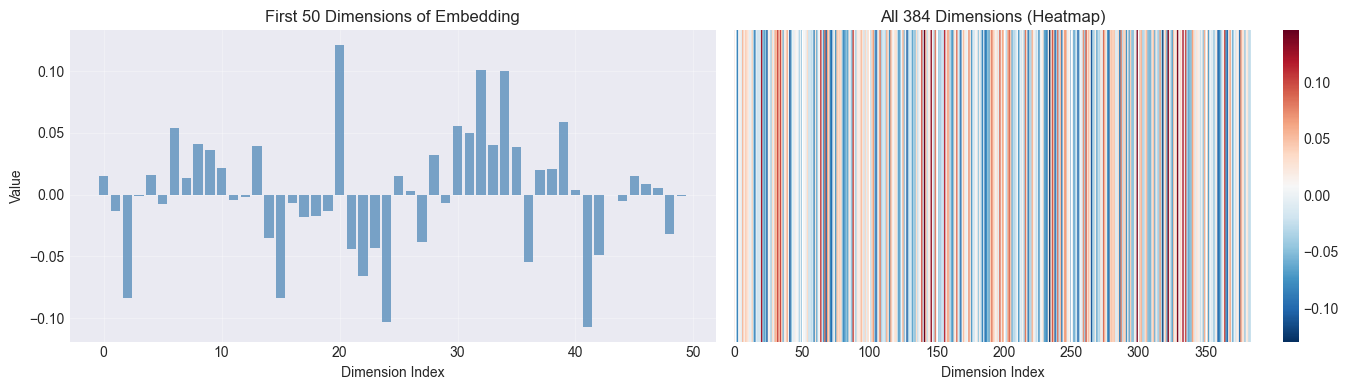


💡 Each dimension captures different semantic aspects of the text.
   Similar chunks will have similar patterns across these dimensions.


In [18]:
# Display first chunk's embedding
sample_embedding = embeddings[0]

print("First Chunk Text:")
print("="*50)
print(chunks[0][:200] + "...")
print("\n" + "="*50)

print(f"\nIts Embedding (first 20 dimensions):")
print(sample_embedding[:20])

print(f"\nFull embedding shape: {sample_embedding.shape}")
print(f"Value range: [{sample_embedding.min():.3f}, {sample_embedding.max():.3f}]")
print(f"Mean: {sample_embedding.mean():.3f}")
print(f"Std dev: {sample_embedding.std():.3f}")

# Visualize the embedding
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Bar chart of first 50 dimensions
ax1.bar(range(50), sample_embedding[:50], color='steelblue', alpha=0.7)
ax1.set_xlabel('Dimension Index')
ax1.set_ylabel('Value')
ax1.set_title(f'First 50 Dimensions of Embedding')
ax1.grid(alpha=0.3)

# Heatmap of all dimensions
im = ax2.imshow(sample_embedding.reshape(-1, 1).T, cmap='RdBu_r', aspect='auto')
ax2.set_xlabel('Dimension Index')
ax2.set_yticks([])
ax2.set_title(f'All {len(sample_embedding)} Dimensions (Heatmap)')
plt.colorbar(im, ax=ax2)

plt.tight_layout()
plt.show()

print("\n💡 Each dimension captures different semantic aspects of the text.")
print("   Similar chunks will have similar patterns across these dimensions.")

---
## Section 4: Chunk Storage

Now we'll store our chunks and their embeddings in a Pandas DataFrame. This structure makes it easy to apply retrieval operations later.

### DataFrame Structure

We'll create a DataFrame with three columns:
- **chunk_id**: Integer index for each chunk
- **text**: The original chunk text
- **embedding**: The embedding vector as a numpy array

### Why Store Text?

Storing the original text alongside embeddings enables:
- **Short-to-long retrieval**: Retrieve a chunk, then expand to surrounding context
- **Metadata enrichment**: Add information to chunks (source, author, date, etc.)
- **Context preservation**: See what was actually embedded

### Technical Note: Storage Design

Storing embeddings in a single column enables efficient retrieval:
```python
df['embedding'].apply(lambda x: util.cos_sim(query_embedding, x))
```

This avoids:
- Memory overhead from multi-column approaches
- Computational complexity of combining columns
- Need for complex indexing structures

In [20]:
# Create DataFrame with chunks and embeddings
df = pd.DataFrame({
    'chunk_id': range(len(chunks)),
    'text': chunks,
    'embedding': list(embeddings)
})

print("DataFrame Created:")
print("="*50)
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nMemory usage:")
print(df.memory_usage(deep=True))

# Display first few rows
print("\n\nFirst 5 rows:")
print("="*50)
display_df = df.head().copy()
display_df['text'] = display_df['text'].str[:100] + '...'  # Truncate for display
display_df['embedding'] = display_df['embedding'].apply(lambda x: f"array({x.shape})")
display(display_df)

DataFrame Created:
Shape: (22, 3)
Columns: ['chunk_id', 'text', 'embedding']

Memory usage:
Index          132
chunk_id       176
text         12193
embedding     2640
dtype: int64


First 5 rows:


,chunk_id,text,embedding
0,0,The study of economics is fundamentally concerned with how societies allocate scarce resources a...,"array((384,))"
1,1,"consumers, firms, and workers. It examines how these agents make decisions about the allocation ...","array((384,))"
2,2,termines the equilibrium price and quantity in a market.\n\nConsumer behavior is analyzed throug...,"array((384,))"
3,3,consuming one more unit decreases. This principle has important implications for understanding ...,"array((384,))"
4,4,duction levels and variable costs that do. Understanding these cost structures is crucial for an...,"array((384,))"


### Note on Vector Databases (For Instructors/Advanced Students)

**In production RAG systems, embeddings are typically stored in specialized vector databases rather than DataFrames.**

#### Common Vector Databases:
- **Pinecone**: Managed vector database with excellent performance
- **Weaviate**: Open-source with GraphQL API
- **Chroma**: Lightweight, embedded vector store
- **Qdrant**: High-performance with advanced filtering
- **Milvus**: Scalable for billions of vectors
- **FAISS**: Facebook's similarity search library

#### Advantages over DataFrames:

1. **Optimized Indexing**: Use structures like HNSW (Hierarchical Navigable Small World) or IVF (Inverted File Index) for fast similarity search at scale
2. **Scalability**: Handle millions or billions of vectors efficiently
3. **Advanced Features**:
   - Metadata filtering (e.g., "find similar docs from 2023")
   - Hybrid search (combine keyword and semantic search)
   - Real-time updates and deletions
4. **Persistence**: Durable storage with backup and replication
5. **Distributed Architecture**: Horizontal scaling across multiple machines

#### When to Use What:
- **DataFrames**: Perfect for learning and prototypes with <10,000 chunks
- **Vector Databases**: Essential for production with >10,000 chunks or real-time requirements

For this educational notebook, DataFrames are ideal because they're simple, transparent, and require no external services.

---
## Section 4.1: Understanding Chunk Similarity Distribution

Before we retrieve chunks, let's understand how similar our chunks are to each other. This helps us evaluate our chunking strategy.

### Why Does This Matter?

- **Too similar (>0.8 avg)**: Chunks may be redundant, making it hard to distinguish the most relevant ones
- **Too disparate (<0.3 avg)**: Chunks may lack coherence, making it hard to retrieve meaningful related context
- **Ideal range (0.4-0.7)**: Good diversity while maintaining topical relationships

Let's visualize the similarity landscape:

Computing pairwise similarities for 22 chunks...

Similarity Statistics:
Mean similarity: 0.315
Std dev: 0.118
Min similarity: 0.044
Max similarity: 0.742


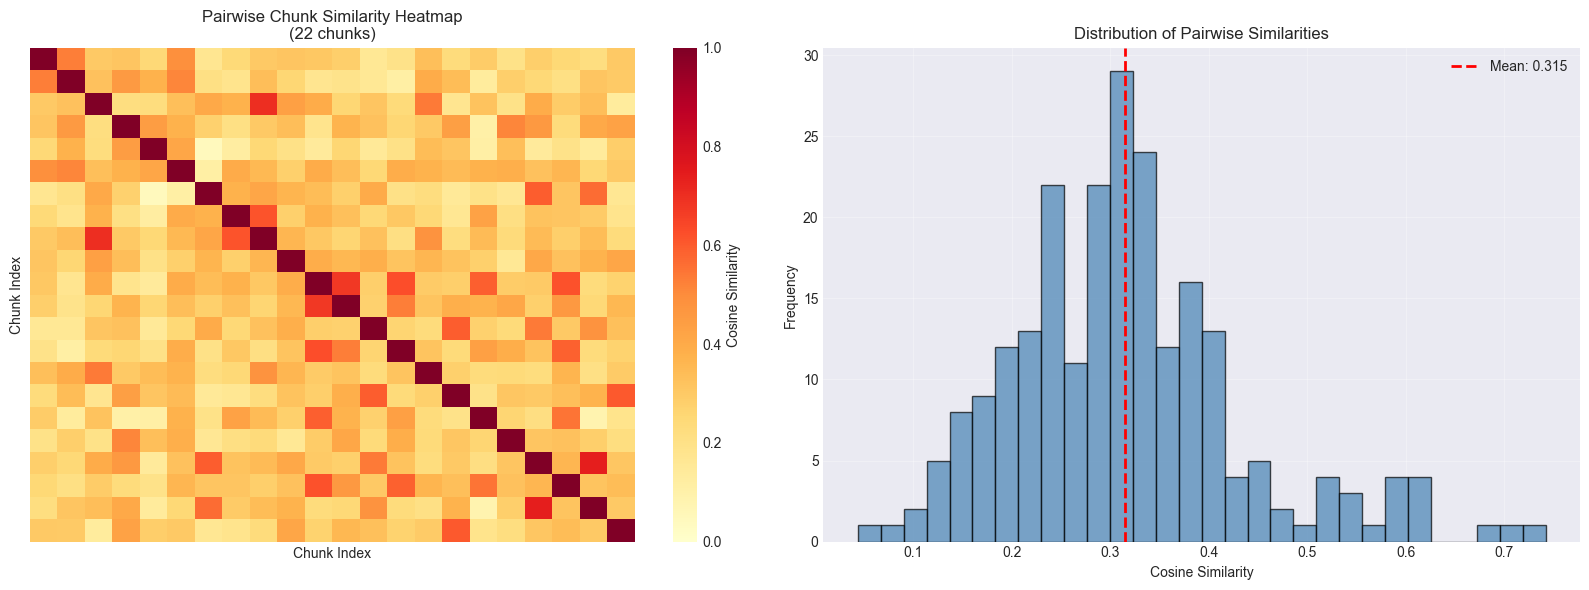


Interpretation:
✓ Good similarity distribution! Chunks have diversity while maintaining coherence.

💡 In the heatmap, bright squares indicate clusters of similar chunks.
   This often represents chunks from the same topic or section of the document.


In [21]:
# Compute pairwise cosine similarities
# For performance, we'll sample if there are too many chunks
sample_size = min(50, len(chunks))  # Use up to 50 chunks for visualization
sample_indices = np.random.choice(len(chunks), sample_size, replace=False)
sample_embeddings = embeddings[sample_indices]

print(f"Computing pairwise similarities for {sample_size} chunks...")
similarity_matrix = util.cos_sim(sample_embeddings, sample_embeddings).numpy()

# Calculate statistics (excluding diagonal which is always 1.0)
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool), k=1)
upper_triangle = similarity_matrix[mask]

print(f"\nSimilarity Statistics:")
print(f"="*50)
print(f"Mean similarity: {upper_triangle.mean():.3f}")
print(f"Std dev: {upper_triangle.std():.3f}")
print(f"Min similarity: {upper_triangle.min():.3f}")
print(f"Max similarity: {upper_triangle.max():.3f}")

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
sns.heatmap(similarity_matrix, cmap='YlOrRd', ax=ax1, 
            xticklabels=False, yticklabels=False,
            vmin=0, vmax=1, cbar_kws={'label': 'Cosine Similarity'})
ax1.set_title(f'Pairwise Chunk Similarity Heatmap\n({sample_size} chunks)', fontsize=12)
ax1.set_xlabel('Chunk Index')
ax1.set_ylabel('Chunk Index')

# Histogram
ax2.hist(upper_triangle, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(upper_triangle.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {upper_triangle.mean():.3f}')
ax2.set_xlabel('Cosine Similarity')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Pairwise Similarities')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation
print("\n" + "="*50)
print("Interpretation:")
if upper_triangle.mean() > 0.8:
    print("⚠ High average similarity (>0.8): Chunks may be redundant.")
    print("  → Consider: Larger chunk sizes or different document")
elif upper_triangle.mean() < 0.3:
    print("⚠ Low average similarity (<0.3): Chunks may be too disparate.")
    print("  → Consider: Smaller chunk sizes or more overlap")
else:
    print("✓ Good similarity distribution! Chunks have diversity while maintaining coherence.")

# Look for clusters in the heatmap
print("\n💡 In the heatmap, bright squares indicate clusters of similar chunks.")
print("   This often represents chunks from the same topic or section of the document.")

---
## Section 4.2: Visualizing Embeddings in Reduced Dimensions

Embeddings exist in high-dimensional space (384 or 768 dimensions), which we can't visualize directly. We'll use **UMAP (Uniform Manifold Approximation and Projection)** to reduce dimensionality to 2D and 3D.

### Mathematical Note: UMAP vs PCA

**PCA (Principal Component Analysis)**:
- Linear dimensionality reduction
- Preserves global structure
- Faster but less nuanced

**UMAP (Uniform Manifold Approximation and Projection)**:
- Non-linear dimensionality reduction based on manifold learning
- Better preserves local structure (nearby points stay nearby)
- Reveals clusters and relationships more clearly
- Slower but more informative for semantic embeddings

For semantic embeddings, UMAP typically provides more meaningful visualizations.

### 2D Visualization with UMAP

In [22]:
# Reduce embeddings to 2D using UMAP
print("Reducing embeddings to 2D with UMAP...")
print("This may take a minute...\n")

reducer_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_2d = reducer_2d.fit_transform(embeddings)

print(f"✓ Reduced to 2D: shape {embeddings_2d.shape}")

# Store in DataFrame
df['umap_x'] = embeddings_2d[:, 0]
df['umap_y'] = embeddings_2d[:, 1]

Reducing embeddings to 2D with UMAP...
This may take a minute...

✓ Reduced to 2D: shape (22, 2)


In [23]:
# OPTION 1: Interactive with ipywidgets
if WIDGETS_AVAILABLE:
    def plot_2d_interactive(num_chunks):
        plot_df = df.head(num_chunks)
        
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(plot_df['umap_x'], plot_df['umap_y'], 
                            c=plot_df['chunk_id'], cmap='viridis', 
                            s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
        
        # Add labels for first few points
        for idx in range(min(10, num_chunks)):
            plt.annotate(str(idx), 
                        (plot_df.iloc[idx]['umap_x'], plot_df.iloc[idx]['umap_y']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.colorbar(scatter, label='Chunk ID')
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.title(f'2D UMAP Projection of {num_chunks} Chunk Embeddings')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    interact(plot_2d_interactive, 
             num_chunks=widgets.IntSlider(min=10, max=len(chunks), step=10, value=min(50, len(chunks))))
else:
    # OPTION 2: Simple version
    NUM_CHUNKS_TO_PLOT = min(50, len(chunks))  # Modify this value
    
    plot_df = df.head(NUM_CHUNKS_TO_PLOT)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(plot_df['umap_x'], plot_df['umap_y'], 
                        c=plot_df['chunk_id'], cmap='viridis', 
                        s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Add labels for first few points
    for idx in range(min(10, NUM_CHUNKS_TO_PLOT)):
        plt.annotate(str(idx), 
                    (plot_df.iloc[idx]['umap_x'], plot_df.iloc[idx]['umap_y']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.colorbar(scatter, label='Chunk ID')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title(f'2D UMAP Projection of {NUM_CHUNKS_TO_PLOT} Chunk Embeddings')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 To change the number of chunks displayed, modify NUM_CHUNKS_TO_PLOT above")

interactive(children=(IntSlider(value=22, description='num_chunks', max=22, min=10, step=10), Output()), _dom_…

### 3D Visualization with UMAP

Now let's create an interactive 3D visualization using Plotly:

In [24]:
# Reduce embeddings to 3D using UMAP
print("Reducing embeddings to 3D with UMAP...")
print("This may take a minute...\n")

reducer_3d = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_3d = reducer_3d.fit_transform(embeddings)

print(f"✓ Reduced to 3D: shape {embeddings_3d.shape}")

# Store in DataFrame
df['umap_x_3d'] = embeddings_3d[:, 0]
df['umap_y_3d'] = embeddings_3d[:, 1]
df['umap_z_3d'] = embeddings_3d[:, 2]

Reducing embeddings to 3D with UMAP...
This may take a minute...

✓ Reduced to 3D: shape (22, 3)


In [25]:
# OPTION 1: Interactive with ipywidgets
if WIDGETS_AVAILABLE:
    def plot_3d_interactive(num_chunks):
        plot_df = df.head(num_chunks)
        
        fig = go.Figure(data=[go.Scatter3d(
            x=plot_df['umap_x_3d'],
            y=plot_df['umap_y_3d'],
            z=plot_df['umap_z_3d'],
            mode='markers',
            marker=dict(
                size=5,
                color=plot_df['chunk_id'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Chunk ID"),
                line=dict(color='black', width=0.5)
            ),
            text=[f"Chunk {i}: {text[:100]}..." for i, text in zip(plot_df['chunk_id'], plot_df['text'])],
            hoverinfo='text'
        )])
        
        fig.update_layout(
            title=f'3D UMAP Projection of {num_chunks} Chunk Embeddings',
            scene=dict(
                xaxis_title='UMAP Dimension 1',
                yaxis_title='UMAP Dimension 2',
                zaxis_title='UMAP Dimension 3'
            ),
            width=900,
            height=700
        )
        
        fig.show()
    
    interact(plot_3d_interactive, 
             num_chunks=widgets.IntSlider(min=10, max=len(chunks), step=10, value=min(50, len(chunks))))
else:
    # OPTION 2: Simple version
    NUM_CHUNKS_3D = min(50, len(chunks))  # Modify this value
    
    plot_df = df.head(NUM_CHUNKS_3D)
    
    fig = go.Figure(data=[go.Scatter3d(
        x=plot_df['umap_x_3d'],
        y=plot_df['umap_y_3d'],
        z=plot_df['umap_z_3d'],
        mode='markers',
        marker=dict(
            size=5,
            color=plot_df['chunk_id'],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Chunk ID"),
            line=dict(color='black', width=0.5)
        ),
        text=[f"Chunk {i}: {text[:100]}..." for i, text in zip(plot_df['chunk_id'], plot_df['text'])],
        hoverinfo='text'
    )])
    
    fig.update_layout(
        title=f'3D UMAP Projection of {NUM_CHUNKS_3D} Chunk Embeddings',
        scene=dict(
            xaxis_title='UMAP Dimension 1',
            yaxis_title='UMAP Dimension 2',
            zaxis_title='UMAP Dimension 3'
        ),
        width=900,
        height=700
    )
    
    fig.show()
    
    print("\n💡 To change the number of chunks displayed, modify NUM_CHUNKS_3D above")
    print("💡 You can rotate, zoom, and pan the 3D plot by clicking and dragging!")

interactive(children=(IntSlider(value=22, description='num_chunks', max=22, min=10, step=10), Output()), _dom_…

---
## Section 5: User Query Embedding

Now we'll create a query and embed it using the same model. The query embedding can then be compared to chunk embeddings to find the most relevant chunks.

### Conceptual Understanding

The query goes through the **exact same embedding process** as the chunks:
1. Text → Tokenization → Model → Embedding vector
2. This ensures queries and chunks exist in the same semantic space
3. Distance/similarity in this space reflects semantic similarity

### Example Queries by Document Type

Choose from these examples or write your own!

In [26]:
# Example queries for each document type
EXAMPLE_QUERIES = {
    "Economic Context": [
        "How do supply and demand determine market prices?",
        "What are the different types of unemployment?",
        "Explain the role of central banks in monetary policy",
        "What causes income inequality in modern economies?"
    ],
    "Literary Context": [
        "What is the difference between Romanticism and Realism?",
        "How do authors use symbolism in literature?",
        "Explain the concept of narrative point of view",
        "What is postcolonial literary criticism?"
    ],
    "Philosophy Context": [
        "What is the mind-body problem in philosophy?",
        "Explain the difference between rationalism and empiricism",
        "What is Kant's categorical imperative?",
        "How does virtue ethics differ from consequentialism?"
    ]
}

# Display example queries for selected document
print(f"Example queries for {SELECTED_DOCUMENT}:")
print("="*50)
for i, query in enumerate(EXAMPLE_QUERIES[SELECTED_DOCUMENT], 1):
    print(f"{i}. {query}")
print("\n" + "="*50)

Example queries for Economic Context:
1. How do supply and demand determine market prices?
2. What are the different types of unemployment?
3. Explain the role of central banks in monetary policy
4. What causes income inequality in modern economies?



In [27]:
# OPTION 1: Interactive with ipywidgets
if WIDGETS_AVAILABLE:
    query_input = widgets.Textarea(
        value=EXAMPLE_QUERIES[SELECTED_DOCUMENT][0],
        placeholder='Enter your query here...',
        description='Query:',
        layout=widgets.Layout(width='80%', height='80px')
    )
    display(query_input)
    print("\n💡 Modify the query above, then run the next cell to embed it")
else:
    # OPTION 2: Simple version
    print("\n💡 Modify the QUERY variable below to try different queries")
    QUERY = EXAMPLE_QUERIES[SELECTED_DOCUMENT][0]  # Change this or write your own!
    print(f"\nCurrent query: {QUERY}")

Textarea(value='How do supply and demand determine market prices?', description='Query:', layout=Layout(height…


💡 Modify the query above, then run the next cell to embed it


In [28]:
# Get the query text
if WIDGETS_AVAILABLE:
    query = query_input.value
else:
    query = QUERY

print(f"Query: {query}")
print("\n" + "="*50)

# Embed the query
print("\nEmbedding query...")
query_embedding = model.encode(query, convert_to_numpy=True)

print(f"✓ Query embedded!")
print(f"  Shape: {query_embedding.shape}")
print(f"  Dimensions: {len(query_embedding)}")

# Show a preview of similarity to first chunk
sample_similarity = util.cos_sim(query_embedding, embeddings[0]).item()
print(f"\nSimilarity to first chunk: {sample_similarity:.4f}")
print(f"First chunk: {chunks[0][:100]}...")

Query: How do supply and demand determine market prices?


Embedding query...
✓ Query embedded!
  Shape: (384,)
  Dimensions: 384

Similarity to first chunk: 0.3424
First chunk: The study of economics is fundamentally concerned with how societies allocate scarce resources among...


---
## Section 6: Chunk Retrieval

Now we'll retrieve the most relevant chunks for our query. We'll explore two retrieval methods:

1. **Top-K Retrieval**: Retrieve the k most similar chunks
2. **Threshold-Based Retrieval**: Retrieve all chunks above a similarity threshold
3. **Combined**: Use both criteria together

### Mathematical Note: Cosine Similarity

Cosine similarity measures the cosine of the angle between two vectors:

**cos(θ) = (A · B) / (||A|| ||B||)**

Where:
- A · B is the dot product of vectors A and B
- ||A|| and ||B|| are the magnitudes (norms) of the vectors

**Range**: -1 to 1
- 1 = identical direction (perfect similarity)
- 0 = orthogonal (no similarity)
- -1 = opposite direction (perfect dissimilarity)

For normalized embeddings (like ours), cosine similarity is equivalent to dot product.

In [29]:
# Calculate cosine similarity between query and all chunks
print("Calculating similarities...")
similarities = util.cos_sim(query_embedding, embeddings)[0].numpy()

# Add similarities to dataframe
df['similarity'] = similarities

print(f"✓ Similarities calculated for {len(similarities)} chunks")
print(f"\nSimilarity Statistics:")
print(f"  Mean: {similarities.mean():.4f}")
print(f"  Std dev: {similarities.std():.4f}")
print(f"  Min: {similarities.min():.4f}")
print(f"  Max: {similarities.max():.4f}")

Calculating similarities...
✓ Similarities calculated for 22 chunks

Similarity Statistics:
  Mean: 0.2870
  Std dev: 0.1668
  Min: 0.0447
  Max: 0.7450


### Method 1: Top-K Retrieval

Retrieve the k most similar chunks regardless of their absolute similarity scores.

In [30]:
# RETRIEVAL PARAMETERS
TOP_K = 5  # Number of chunks to retrieve

# Retrieve top-k chunks
top_k_results = df.nlargest(TOP_K, 'similarity')[['chunk_id', 'text', 'similarity']].copy()

print(f"Top {TOP_K} Most Similar Chunks:")
print("="*80)
for idx, row in top_k_results.iterrows():
    print(f"\nChunk {row['chunk_id']} | Similarity: {row['similarity']:.4f}")
    print(f"{row['text'][:300]}...")
    print("-"*80)

Top 5 Most Similar Chunks:

Chunk 1 | Similarity: 0.7450
consumers, firms, and workers. It examines how these agents make decisions about the allocation of resources and how these decisions interact in markets. The concept of supply and demand is central to microeconomic analysis. Supply represents the quantity of a good or service that producers are will...
--------------------------------------------------------------------------------

Chunk 4 | Similarity: 0.5863
duction levels and variable costs that do. Understanding these cost structures is crucial for analyzing firm behavior and market outcomes.

Market structures vary significantly, from perfect competition to monopoly, with oligopoly and monopolistic competition in between. In perfectly competitive mar...
--------------------------------------------------------------------------------

Chunk 3 | Similarity: 0.4559
 consuming one more unit decreases. This principle has important implications for understanding demand curves and

### Method 2: Threshold-Based Retrieval

Retrieve all chunks above a certain similarity threshold.

In [31]:
# THRESHOLD PARAMETER
SIMILARITY_THRESHOLD = 0.3  # Minimum similarity score (0.0 to 1.0)

# Retrieve chunks above threshold
threshold_results = df[df['similarity'] >= SIMILARITY_THRESHOLD].nlargest(20, 'similarity')[['chunk_id', 'text', 'similarity']].copy()

print(f"Chunks with Similarity >= {SIMILARITY_THRESHOLD}:")
print("="*80)
print(f"Found {len(threshold_results)} chunks\n")

for idx, row in threshold_results.head(5).iterrows():  # Show top 5
    print(f"\nChunk {row['chunk_id']} | Similarity: {row['similarity']:.4f}")
    print(f"{row['text'][:300]}...")
    print("-"*80)

Chunks with Similarity >= 0.3:
Found 9 chunks


Chunk 1 | Similarity: 0.7450
consumers, firms, and workers. It examines how these agents make decisions about the allocation of resources and how these decisions interact in markets. The concept of supply and demand is central to microeconomic analysis. Supply represents the quantity of a good or service that producers are will...
--------------------------------------------------------------------------------

Chunk 4 | Similarity: 0.5863
duction levels and variable costs that do. Understanding these cost structures is crucial for analyzing firm behavior and market outcomes.

Market structures vary significantly, from perfect competition to monopoly, with oligopoly and monopolistic competition in between. In perfectly competitive mar...
--------------------------------------------------------------------------------

Chunk 3 | Similarity: 0.4559
 consuming one more unit decreases. This principle has important implications for understandi

### Method 3: Combined (Top-K AND Threshold)

Retrieve up to k chunks that also meet the threshold requirement.

In [32]:
# Combined retrieval
combined_results = df[df['similarity'] >= SIMILARITY_THRESHOLD].nlargest(TOP_K, 'similarity')[['chunk_id', 'text', 'similarity']].copy()

print(f"Combined Retrieval (Top {TOP_K} with Similarity >= {SIMILARITY_THRESHOLD}):")
print("="*80)
print(f"Retrieved {len(combined_results)} chunks\n")

for idx, row in combined_results.iterrows():
    print(f"\nChunk {row['chunk_id']} | Similarity: {row['similarity']:.4f}")
    print(f"{row['text'][:300]}...")
    print("-"*80)

Combined Retrieval (Top 5 with Similarity >= 0.3):
Retrieved 5 chunks


Chunk 1 | Similarity: 0.7450
consumers, firms, and workers. It examines how these agents make decisions about the allocation of resources and how these decisions interact in markets. The concept of supply and demand is central to microeconomic analysis. Supply represents the quantity of a good or service that producers are will...
--------------------------------------------------------------------------------

Chunk 4 | Similarity: 0.5863
duction levels and variable costs that do. Understanding these cost structures is crucial for analyzing firm behavior and market outcomes.

Market structures vary significantly, from perfect competition to monopoly, with oligopoly and monopolistic competition in between. In perfectly competitive mar...
--------------------------------------------------------------------------------

Chunk 3 | Similarity: 0.4559
 consuming one more unit decreases. This principle has important impl

### Comparison of Retrieval Methods

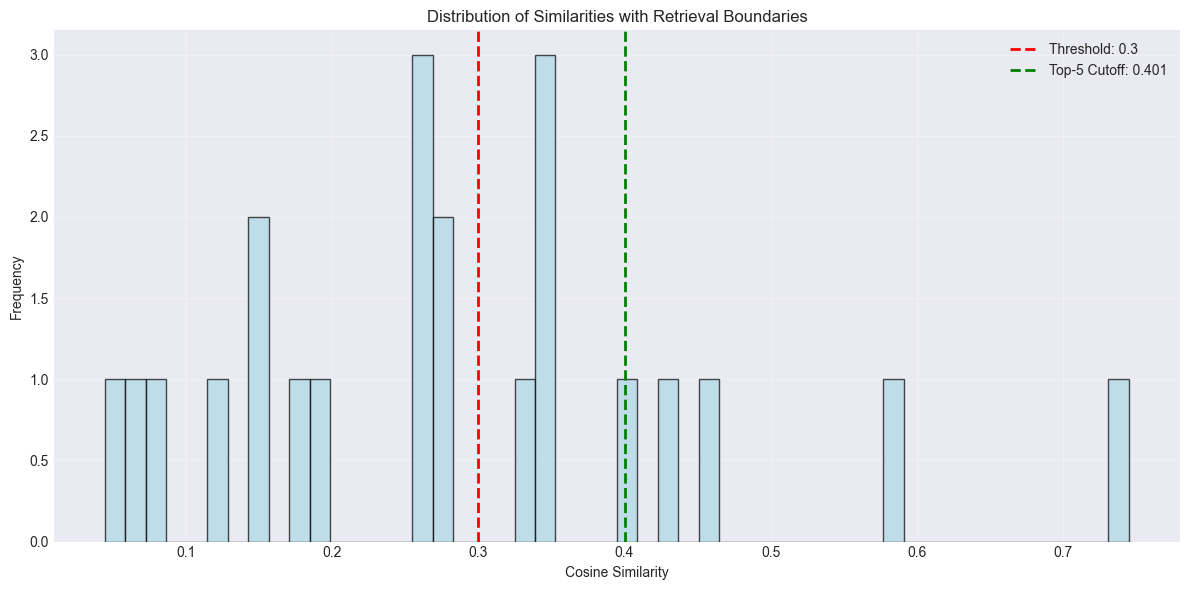


Retrieval Method Comparison:
Top-K (5): 5 chunks retrieved
Threshold (>=0.3): 9 chunks retrieved
Combined: 5 chunks retrieved

💡 Trade-offs:
  - Top-K: Guarantees fixed number of results, but may include irrelevant chunks
  - Threshold: Ensures quality, but number of results varies
  - Combined: Best of both - quality assurance with upper limit


In [33]:
# Visualize similarity distribution with retrieval boundaries
plt.figure(figsize=(12, 6))

plt.hist(similarities, bins=50, color='lightblue', alpha=0.7, edgecolor='black')
plt.axvline(SIMILARITY_THRESHOLD, color='red', linestyle='--', linewidth=2, 
            label=f'Threshold: {SIMILARITY_THRESHOLD}')

# Mark top-k cutoff
if len(top_k_results) > 0:
    top_k_cutoff = top_k_results.iloc[-1]['similarity']
    plt.axvline(top_k_cutoff, color='green', linestyle='--', linewidth=2,
                label=f'Top-{TOP_K} Cutoff: {top_k_cutoff:.3f}')

plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Similarities with Retrieval Boundaries')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nRetrieval Method Comparison:")
print("="*50)
print(f"Top-K ({TOP_K}): {len(top_k_results)} chunks retrieved")
print(f"Threshold (>={SIMILARITY_THRESHOLD}): {len(threshold_results)} chunks retrieved")
print(f"Combined: {len(combined_results)} chunks retrieved")

print("\n💡 Trade-offs:")
print("  - Top-K: Guarantees fixed number of results, but may include irrelevant chunks")
print("  - Threshold: Ensures quality, but number of results varies")
print("  - Combined: Best of both - quality assurance with upper limit")

### Note on Reranking (For Instructors/Advanced Students)

**After initial retrieval, production systems often use a reranking step to improve result quality.**

#### Why Rerank?

1. **Two-Stage Pipeline**: 
   - First stage (what we just did): Fast, broad retrieval using embeddings
   - Second stage (reranking): Slower, more accurate scoring of candidates

2. **Embedding Limitations**:
   - Embedding similarity captures general semantic similarity
   - May miss nuanced relevance signals
   - Single vector per chunk loses fine-grained information

3. **Reranker Advantages**:
   - Cross-attention between query and passage
   - More computationally expensive (hence used on smaller candidate set)
   - Better at determining exact relevance

#### Common Reranking Approaches:

1. **Cross-Encoder Models**:
   - BERT-based models that process query and passage together
   - Examples: `cross-encoder/ms-marco-MiniLM-L-6-v2`
   - More accurate but ~100x slower than bi-encoders

2. **Commercial APIs**:
   - Cohere Rerank API
   - Voyage AI Rerank
   - Easy to integrate, high quality

3. **Hybrid Approaches**:
   - Combine with keyword search (BM25)
   - Use metadata signals (recency, source authority)
   - Learning-to-rank models

#### Typical Production Pipeline:

```
Query → Embed → Retrieve top-100 (fast, embedding similarity)
      → Rerank top-100 to top-10 (slower, cross-encoder)
      → Pass top-10 to LLM for generation
```

**For this educational notebook, we skip reranking to focus on core RAG concepts, but it's valuable in production systems where quality matters more than speed.**

---
## Section 6.1: Visualizing Query in Embedding Space

Let's visualize where our query sits in the embedding space and see which chunks fall within the retrieval boundary.

### Mathematical Note: Distance Metrics

The radius we'll draw represents the **maximum distance** to retrieved chunks:

- For top-k: Distance to the k-th ranked chunk
- For threshold: Distance corresponding to the similarity threshold
- Distance in UMAP space ≠ cosine similarity (UMAP distorts distances)
- But relative positions are preserved

This visualization helps understand the **similarity boundary** concept.

In [34]:
# Embed the query in 2D space using the same UMAP reducer
query_2d = reducer_2d.transform(query_embedding.reshape(1, -1))[0]

# Store retrieval method choice
RETRIEVAL_METHOD = "top_k"  # Options: "top_k", "threshold", "combined"

# Get retrieved chunk IDs based on method
if RETRIEVAL_METHOD == "top_k":
    retrieved_ids = set(top_k_results['chunk_id'])
    cutoff_similarity = top_k_results.iloc[-1]['similarity']
elif RETRIEVAL_METHOD == "threshold":
    retrieved_ids = set(threshold_results['chunk_id'])
    cutoff_similarity = SIMILARITY_THRESHOLD
else:  # combined
    retrieved_ids = set(combined_results['chunk_id'])
    cutoff_similarity = combined_results.iloc[-1]['similarity'] if len(combined_results) > 0 else SIMILARITY_THRESHOLD

# Calculate radius in UMAP space (approximate)
retrieved_points = df[df['chunk_id'].isin(retrieved_ids)][['umap_x', 'umap_y']].values
if len(retrieved_points) > 0:
    distances = np.sqrt(np.sum((retrieved_points - query_2d)**2, axis=1))
    radius = distances.max()
else:
    radius = 0

print(f"Query embedded in 2D UMAP space")
print(f"Retrieval method: {RETRIEVAL_METHOD}")
print(f"Retrieved chunks: {len(retrieved_ids)}")
print(f"Cutoff similarity: {cutoff_similarity:.4f}")
print(f"Visualization radius: {radius:.4f}")

Query embedded in 2D UMAP space
Retrieval method: top_k
Retrieved chunks: 5
Cutoff similarity: 0.4006
Visualization radius: 2.0423


### 2D Visualization with Query

In [37]:
# OPTION 1: Interactive with ipywidgets
if WIDGETS_AVAILABLE:
    def plot_query_2d_interactive(num_chunks):
        plot_df = df.head(num_chunks)
        
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # Plot non-retrieved chunks in gray
        non_retrieved = plot_df[~plot_df['chunk_id'].isin(retrieved_ids)]
        ax.scatter(non_retrieved['umap_x'], non_retrieved['umap_y'], 
                  c='lightgray', s=50, alpha=0.3, label='Not Retrieved')
        
        # Plot retrieved chunks in green
        retrieved = plot_df[plot_df['chunk_id'].isin(retrieved_ids)]
        ax.scatter(retrieved['umap_x'], retrieved['umap_y'], 
                  c='limegreen', s=150, alpha=0.7, edgecolors='darkgreen', 
                  linewidth=2, label='Retrieved', marker='o')
        
        # Plot query as red star
        ax.scatter(query_2d[0], query_2d[1], c='red', s=500, marker='*', 
                  edgecolors='darkred', linewidth=2, label='Query', zorder=5)
        
        # Draw circle around query
        circle = plt.Circle((query_2d[0], query_2d[1]), radius, 
                           color='blue', fill=False, linestyle='--', 
                           linewidth=2, alpha=0.5, label=f'Retrieval Boundary')
        ax.add_patch(circle)
        
        # Draw filled circle with transparency
        circle_fill = plt.Circle((query_2d[0], query_2d[1]), radius, 
                                color='lightblue', alpha=0.1)
        ax.add_patch(circle_fill)
        
        ax.set_xlabel('UMAP Dimension 1', fontsize=12)
        ax.set_ylabel('UMAP Dimension 2', fontsize=12)
        ax.set_title(f'Query and Retrieved Chunks in 2D Embedding Space\n' + 
                    f'Method: {RETRIEVAL_METHOD} | Retrieved: {len(retrieved_ids)} chunks',
                    fontsize=14),ax.legend(loc='best', fontsize=10)
        ax.grid(alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
        plt.tight_layout()
        plt.show()
    
    interact(plot_query_2d_interactive, 
             num_chunks=widgets.IntSlider(min=10, max=len(chunks), step=10, value=min(50, len(chunks))))
else:
    # OPTION 2: Simple version
    NUM_CHUNKS_QUERY = min(50, len(chunks))  # Modify this value
    
    plot_df = df.head(NUM_CHUNKS_QUERY)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot non-retrieved chunks in gray
    non_retrieved = plot_df[~plot_df['chunk_id'].isin(retrieved_ids)]
    ax.scatter(non_retrieved['umap_x'], non_retrieved['umap_y'], 
              c='lightgray', s=50, alpha=0.3, label='Not Retrieved')
    
    # Plot retrieved chunks in green
    retrieved = plot_df[plot_df['chunk_id'].isin(retrieved_ids)]
    ax.scatter(retrieved['umap_x'], retrieved['umap_y'], 
              c='limegreen', s=150, alpha=0.7, edgecolors='darkgreen', 
              linewidth=2, label='Retrieved', marker='o')
    
    # Plot query as red star
    ax.scatter(query_2d[0], query_2d[1], c='red', s=500, marker='*', 
              edgecolors='darkred', linewidth=2, label='Query', zorder=5)
    
    # Draw circle around query
    circle = plt.Circle((query_2d[0], query_2d[1]), radius, 
                       color='blue', fill=False, linestyle='--', 
                       linewidth=2, alpha=0.5, label=f'Retrieval Boundary')
    ax.add_patch(circle)
    
    # Draw filled circle with transparency
    circle_fill = plt.Circle((query_2d[0], query_2d[1]), radius, 
                            color='lightblue', alpha=0.1)
    ax.add_patch(circle_fill)
    
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    ax.set_title(f'Query and Retrieved Chunks in 2D Embedding Space\n' + 
                f'Method: {RETRIEVAL_METHOD} | Retrieved: {len(retrieved_ids)} chunks',
                fontsize=14)
    ax.legend(loc='best', fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 To change the number of chunks displayed, modify NUM_CHUNKS_QUERY above")

interactive(children=(IntSlider(value=22, description='num_chunks', max=22, min=10, step=10), Output()), _dom_…

### 3D Visualization with Query

In [38]:
# Embed the query in 3D space
query_3d = reducer_3d.transform(query_embedding.reshape(1, -1))[0]

# Calculate radius in 3D space
retrieved_points_3d = df[df['chunk_id'].isin(retrieved_ids)][['umap_x_3d', 'umap_y_3d', 'umap_z_3d']].values
if len(retrieved_points_3d) > 0:
    distances_3d = np.sqrt(np.sum((retrieved_points_3d - query_3d)**2, axis=1))
    radius_3d = distances_3d.max()
else:
    radius_3d = 0

print(f"Query embedded in 3D UMAP space")
print(f"3D visualization radius: {radius_3d:.4f}")

Query embedded in 3D UMAP space
3D visualization radius: 1.9791


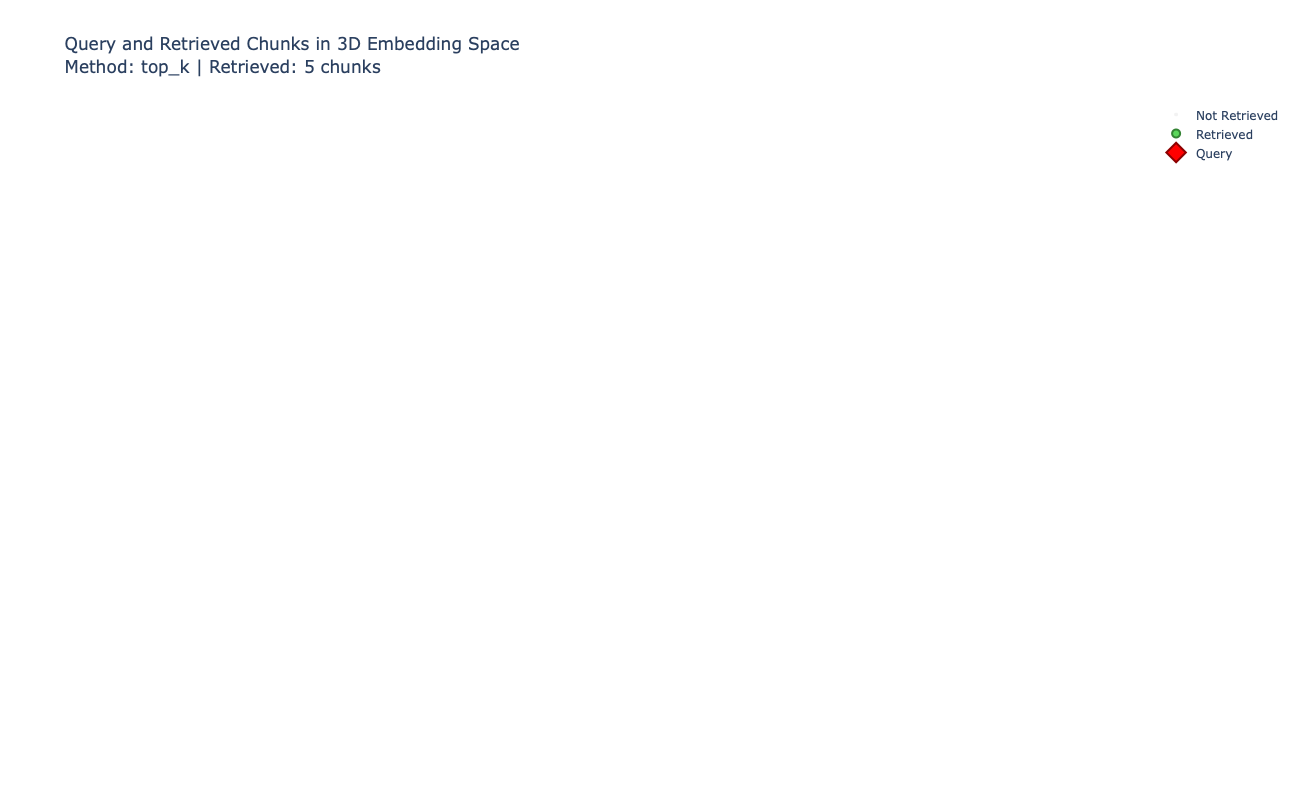


💡 Rotate, zoom, and pan the 3D plot to explore!
💡 The blue sphere shows the retrieval boundary
💡 Green points inside the sphere are retrieved chunks


In [39]:
# Create 3D visualization
NUM_CHUNKS_QUERY_3D = min(50, len(chunks))  # Modify if not using widgets

plot_df = df.head(NUM_CHUNKS_QUERY_3D)

# Separate retrieved and non-retrieved
non_retrieved = plot_df[~plot_df['chunk_id'].isin(retrieved_ids)]
retrieved = plot_df[plot_df['chunk_id'].isin(retrieved_ids)]

# Create traces
trace_non_retrieved = go.Scatter3d(
    x=non_retrieved['umap_x_3d'],
    y=non_retrieved['umap_y_3d'],
    z=non_retrieved['umap_z_3d'],
    mode='markers',
    name='Not Retrieved',
    marker=dict(size=4, color='lightgray', opacity=0.3),
    text=[f"Chunk {i}" for i in non_retrieved['chunk_id']],
    hoverinfo='text'
)

trace_retrieved = go.Scatter3d(
    x=retrieved['umap_x_3d'],
    y=retrieved['umap_y_3d'],
    z=retrieved['umap_z_3d'],
    mode='markers',
    name='Retrieved',
    marker=dict(size=8, color='limegreen', opacity=0.8, 
                line=dict(color='darkgreen', width=2)),
    text=[f"Chunk {i}: {text[:100]}..." for i, text in zip(retrieved['chunk_id'], retrieved['text'])],
    hoverinfo='text'
)

trace_query = go.Scatter3d(
    x=[query_3d[0]],
    y=[query_3d[1]],
    z=[query_3d[2]],
    mode='markers',
    name='Query',
    marker=dict(size=15, color='red', symbol='diamond',
                line=dict(color='darkred', width=2)),
    text=[f"Query: {query}"],
    hoverinfo='text'
)

# Create sphere surface
u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 50)
x_sphere = radius_3d * np.outer(np.cos(u), np.sin(v)) + query_3d[0]
y_sphere = radius_3d * np.outer(np.sin(u), np.sin(v)) + query_3d[1]
z_sphere = radius_3d * np.outer(np.ones(np.size(u)), np.cos(v)) + query_3d[2]

trace_sphere = go.Surface(
    x=x_sphere,
    y=y_sphere,
    z=z_sphere,
    name='Retrieval Boundary',
    colorscale=[[0, 'lightblue'], [1, 'lightblue']],
    opacity=0.2,
    showscale=False,
    hoverinfo='skip'
)

# Create figure
fig = go.Figure(data=[trace_non_retrieved, trace_retrieved, trace_query, trace_sphere])

fig.update_layout(
    title=f'Query and Retrieved Chunks in 3D Embedding Space<br>' + 
          f'Method: {RETRIEVAL_METHOD} | Retrieved: {len(retrieved_ids)} chunks',
    scene=dict(
        xaxis_title='UMAP Dimension 1',
        yaxis_title='UMAP Dimension 2',
        zaxis_title='UMAP Dimension 3',
        aspectmode='data'
    ),
    width=1000,
    height=800
)

fig.show()

print("\n💡 Rotate, zoom, and pan the 3D plot to explore!")
print("💡 The blue sphere shows the retrieval boundary")
print("💡 Green points inside the sphere are retrieved chunks")

### Interpretation

**What do these visualizations tell us?**

1. **Circle/Sphere Radius**: Shows the similarity boundary for retrieval
   - With **top-k**: Radius changes based on the k-th most similar chunk
   - With **threshold**: Radius represents a fixed similarity cutoff
   - With **combined**: Uses the more restrictive boundary

2. **Retrieved Chunks (Green)**: These chunks fall within the retrieval boundary
   - Closest to the query in semantic space
   - Most relevant to answering the query

3. **Non-Retrieved Chunks (Gray)**: Outside the boundary
   - Less semantically similar to the query
   - Not included in the context for generation

**Discussion Questions:**
- When would you prefer **top-k** vs **threshold**?
  - Top-k: When you need a fixed number of results (e.g., limited context window)
  - Threshold: When quality matters more than quantity
- What happens if the threshold is too high? Too low?
  - Too high: May retrieve nothing
  - Too low: May retrieve irrelevant chunks
- How does chunk size affect retrieval?
  - Smaller chunks: More precise but may lack context
  - Larger chunks: More context but less precise

---
## Section 7: Prompt Construction & RAG Pipeline

Now we'll construct a complete prompt that combines our query with the retrieved chunks. This prompt would typically be sent to an LLM (like GPT-4 or Claude) to generate a grounded response.

### How Retrieved Context Augments Generation

The LLM receives:
1. **System instructions**: How to behave and use the context
2. **Retrieved chunks**: Relevant information from our document
3. **User query**: The original question

This allows the LLM to:
- Answer based on specific, provided information
- Avoid hallucinating facts
- Cite sources (chunk IDs)
- Stay grounded in the document

### Prompt Template Structure

We'll use a modular template that you can customize:

In [40]:
# Default prompt templates for each document type
DEFAULT_TEMPLATES = {
    "Economic Context": {
        "preamble": "You are an expert economics tutor helping students understand economic concepts.",
        "instruction_1": "Use the following excerpts from an economics textbook to answer the student's question. Only use information from these excerpts.",
        "instruction_2": "Provide a clear, concise answer that directly addresses the question. If the excerpts don't contain enough information, say so."
    },
    "Literary Context": {
        "preamble": "You are a literature professor helping students analyze literary concepts and techniques.",
        "instruction_1": "Use the following excerpts from a literature textbook to answer the student's question. Base your response only on these excerpts.",
        "instruction_2": "Explain the concept clearly with examples from the provided text. If the excerpts are insufficient, acknowledge this."
    },
    "Philosophy Context": {
        "preamble": "You are a philosophy instructor helping students understand philosophical concepts and arguments.",
        "instruction_1": "Use the following excerpts from a philosophy textbook to answer the student's question. Ground your response in these excerpts.",
        "instruction_2": "Provide a thoughtful explanation that addresses the philosophical question. If the excerpts lack necessary information, indicate this."
    }
}

# Get default template for selected document
template = DEFAULT_TEMPLATES[SELECTED_DOCUMENT]

print("Default Prompt Template:")
print("="*80)
print(f"\n[SYSTEM_PREAMBLE]\n{template['preamble']}")
print(f"\n[INSTRUCTION_1]\n{template['instruction_1']}")
print(f"\n[INSTRUCTION_2]\n{template['instruction_2']}")
print("\n" + "="*80)

Default Prompt Template:

[SYSTEM_PREAMBLE]
You are an expert economics tutor helping students understand economic concepts.

[INSTRUCTION_1]
Use the following excerpts from an economics textbook to answer the student's question. Only use information from these excerpts.

[INSTRUCTION_2]
Provide a clear, concise answer that directly addresses the question. If the excerpts don't contain enough information, say so.



In [41]:
# OPTION 1: Interactive with ipywidgets
if WIDGETS_AVAILABLE:
    preamble_widget = widgets.Textarea(
        value=template['preamble'],
        description='Preamble:',
        layout=widgets.Layout(width='90%', height='60px')
    )
    instruction1_widget = widgets.Textarea(
        value=template['instruction_1'],
        description='Instruction 1:',
        layout=widgets.Layout(width='90%', height='80px')
    )
    instruction2_widget = widgets.Textarea(
        value=template['instruction_2'],
        description='Instruction 2:',
        layout=widgets.Layout(width='90%', height='80px')
    )
    
    print("Customize the prompt template below:")
    display(preamble_widget)
    display(instruction1_widget)
    display(instruction2_widget)
    print("\n💡 Modify the templates above, then run the next cell to build the full prompt")
else:
    # OPTION 2: Simple version
    PREAMBLE = template['preamble']
    INSTRUCTION_1 = template['instruction_1']
    INSTRUCTION_2 = template['instruction_2']
    
    print("💡 To customize the prompt, modify PREAMBLE, INSTRUCTION_1, and INSTRUCTION_2 above")

Customize the prompt template below:


Textarea(value='You are an expert economics tutor helping students understand economic concepts.', description…

Textarea(value="Use the following excerpts from an economics textbook to answer the student's question. Only u…

Textarea(value="Provide a clear, concise answer that directly addresses the question. If the excerpts don't co…


💡 Modify the templates above, then run the next cell to build the full prompt


In [42]:
# Get prompt components
if WIDGETS_AVAILABLE:
    preamble = preamble_widget.value
    instruction_1 = instruction1_widget.value
    instruction_2 = instruction2_widget.value
else:
    preamble = PREAMBLE
    instruction_1 = INSTRUCTION_1
    instruction_2 = INSTRUCTION_2

# Use the combined results (or whichever method you prefer)
results_to_use = combined_results if len(combined_results) > 0 else top_k_results

# Format retrieved chunks
retrieved_context = ""
for idx, row in results_to_use.iterrows():
    retrieved_context += f"\n--- Excerpt {row['chunk_id']} (Similarity: {row['similarity']:.4f}) ---\n"
    retrieved_context += row['text']
    retrieved_context += "\n"

# Construct full prompt
full_prompt = f"""[SYSTEM PREAMBLE]
{preamble}

[INSTRUCTION]
{instruction_1}

[RETRIEVED CONTEXT]
{retrieved_context}

[INSTRUCTION]
{instruction_2}

[USER QUERY]
{query}
"""

# Display the full prompt
print("Full RAG Prompt:")
print("="*80)
print(full_prompt)
print("="*80)

# Calculate token count (rough estimate: 1 token ≈ 4 characters)
estimated_tokens = len(full_prompt) // 4
print(f"\nPrompt Statistics:")
print(f"  Characters: {len(full_prompt):,}")
print(f"  Estimated tokens: ~{estimated_tokens:,}")
print(f"  Retrieved chunks: {len(results_to_use)}")
print(f"  Retrieval method: {RETRIEVAL_METHOD}")

Full RAG Prompt:
[SYSTEM PREAMBLE]
You are an expert economics tutor helping students understand economic concepts.

[INSTRUCTION]
Use the following excerpts from an economics textbook to answer the student's question. Only use information from these excerpts.

[RETRIEVED CONTEXT]

--- Excerpt 1 (Similarity: 0.7450) ---
consumers, firms, and workers. It examines how these agents make decisions about the allocation of resources and how these decisions interact in markets. The concept of supply and demand is central to microeconomic analysis. Supply represents the quantity of a good or service that producers are willing to sell at various prices, while demand represents the quantity that consumers are willing to buy. The intersection of supply and demand curves determines the equilibrium price and quantity in a m

--- Excerpt 4 (Similarity: 0.5863) ---
duction levels and variable costs that do. Understanding these cost structures is crucial for analyzing firm behavior and market outcomes

### Mathematical/Technical Note: Token Counting and Context Windows

**Token Counting**:
- Tokens are the units LLMs process
- Rough estimate: 1 token ≈ 0.75 words ≈ 4 characters (for English)
- Actual tokenization varies by model

**Context Windows** (as of 2024):
- GPT-4: 8k-128k tokens depending on variant
- Claude: 200k tokens
- Gemini: 1M+ tokens

**Prompt Engineering Considerations**:
1. **Context Length**: Balance between including enough context and staying within limits
2. **Chunk Order**: Most relevant chunks first (LLMs can suffer from "lost in the middle")
3. **Instruction Clarity**: Clear instructions improve response quality
4. **Format Consistency**: Structured prompts help LLMs parse information

**What Happens Next** (not shown in this notebook):
1. This prompt would be sent to an LLM API (e.g., OpenAI, Anthropic)
2. The LLM generates a response based on the retrieved context
3. The response is grounded in your document, reducing hallucinations

**Example API call** (pseudocode):
```python
response = llm_api.generate(
    prompt=full_prompt,
    max_tokens=500,
    temperature=0.7
)
```

---
## Section 8: Experimentation & Analysis

Now that you understand the complete RAG pipeline, let's experiment with different configurations to see how they affect results.

### Guided Experiments

Try these experiments and observe the differences:

### Experiment 1: Different Chunk Sizes

**Hypothesis**: Chunk size affects retrieval precision and context quality.

**Instructions**:
1. Go back to Section 2
2. Try `CHUNK_SIZE=200` vs `CHUNK_SIZE=1000`
3. Re-run all subsequent cells
4. Compare retrieved chunks and their relevance

**Questions to consider**:
- Do smaller chunks retrieve more precise information?
- Do larger chunks provide better context?
- How does chunk size affect the number of chunks created?

### Experiment 2: Top-K vs Threshold

**Hypothesis**: Different retrieval methods suit different scenarios.

**Instructions**:
1. Go to Section 6
2. Try `TOP_K=3` vs `TOP_K=10`
3. Try `SIMILARITY_THRESHOLD=0.2` vs `SIMILARITY_THRESHOLD=0.5`
4. Observe which chunks are retrieved

**Questions to consider**:
- When would you want fewer, high-quality chunks?
- When would you want more chunks for comprehensive coverage?
- How does threshold affect the number of retrieved chunks?

### Experiment 3: Different Embedding Models

**Hypothesis**: Higher-quality models produce better embeddings.

**Instructions**:
1. Go to Configuration Section
2. Change `MODEL_NAME` from `"all-MiniLM-L6-v2"` to `"all-mpnet-base-v2"`
3. Re-run from Section 3 onwards
4. Compare retrieval results and similarities

**Questions to consider**:
- Are similarity scores higher or lower?
- Are the retrieved chunks more relevant?
- Is the speed difference noticeable?

### Experiment 4: Different Queries

**Hypothesis**: Query specificity affects retrieval quality.

**Instructions**:
1. Try a vague query: "Tell me about economics"
2. Try a specific query: "What is the difference between frictional and structural unemployment?"
3. Compare retrieved chunks

**Questions to consider**:
- Do specific queries retrieve more focused chunks?
- Do vague queries return diverse but less relevant results?
- How should you phrase queries for best results?

### Experiment 5: Different Documents

**Hypothesis**: Document type affects embedding distributions.

**Instructions**:
1. Go to Section 1
2. Change `SELECTED_DOCUMENT` to a different document
3. Re-run all cells with a relevant query
4. Compare similarity distributions and embeddings

**Questions to consider**:
- Does the literary document show different patterns than philosophy?
- Are some documents more homogeneous than others?
- How does document structure affect chunking?

In [43]:
# Use this cell to document your experimental findings

print("Experimental Log")
print("="*80)
print(f"\nCurrent Configuration:")
print(f"  Document: {SELECTED_DOCUMENT}")
print(f"  Model: {MODEL_NAME}")
print(f"  Chunk size: {CHUNK_SIZE}")
print(f"  Overlap: {OVERLAP}")
print(f"  Total chunks: {len(chunks)}")
print(f"  Query: {query}")
print(f"  Top-K: {TOP_K}")
print(f"  Threshold: {SIMILARITY_THRESHOLD}")
print(f"  Retrieved: {len(results_to_use)} chunks")
print(f"\nAverage similarity: {df['similarity'].mean():.4f}")
print(f"Max similarity: {df['similarity'].max():.4f}")
print(f"Min similarity: {df['similarity'].min():.4f}")

print("\n" + "="*80)
print("\n📝 Add your observations here:")
print("- What worked well?")
print("- What could be improved?")
print("- What surprised you?")

Experimental Log

Current Configuration:
  Document: Economic Context
  Model: all-MiniLM-L6-v2
  Chunk size: 500
  Overlap: 50
  Total chunks: 22
  Query: How do supply and demand determine market prices?
  Top-K: 5
  Threshold: 0.3
  Retrieved: 5 chunks

Average similarity: 0.2870
Max similarity: 0.7450
Min similarity: 0.0447


📝 Add your observations here:
- What worked well?
- What could be improved?
- What surprised you?


---
## Conclusion

Congratulations! You've built a complete RAG system from scratch. Let's recap what you've learned:

### Key Takeaways

1. **Chunking Strategy Matters**
   - Chunk size affects precision vs context trade-off
   - Overlap prevents information loss at boundaries
   - Different documents may need different chunking strategies

2. **Embeddings Capture Semantics**
   - High-dimensional vectors represent meaning
   - Similar content clusters together in embedding space
   - Model choice affects embedding quality

3. **Retrieval Methods Have Trade-offs**
   - **Top-K**: Guarantees fixed results, may include irrelevant chunks
   - **Threshold**: Ensures quality, variable result count
   - **Combined**: Best of both worlds

4. **Visualization Aids Understanding**
   - UMAP reveals structure in embedding space
   - Similarity distributions show chunk relationships
   - Query visualization shows retrieval boundaries

5. **Prompt Engineering is Critical**
   - Clear instructions improve LLM responses
   - Retrieved context grounds generation
   - Token limits constrain how much context you can include

### Limitations of This Implementation

1. **Simple Chunking**: We used character-based chunking
   - Better: Semantic chunking (split at sentence/paragraph boundaries)
   - Better: Recursive chunking (hierarchical structures)

2. **No Reranking**: We used only embedding similarity
   - Better: Cross-encoder reranking for top candidates
   - Better: Hybrid search (embeddings + keyword matching)

3. **DataFrame Storage**: Not scalable beyond 10k chunks
   - Better: Vector databases (Pinecone, Weaviate, Chroma)
   - Better: Optimized indexing (HNSW, IVF)

4. **Single Retrieval Pass**: We retrieve once per query
   - Better: Iterative retrieval (retrieve, evaluate, retrieve more)
   - Better: Multi-hop reasoning (chain of retrievals)

5. **No Metadata**: We only stored text and embeddings
   - Better: Include source, date, author, section
   - Better: Enable metadata filtering

### Advanced Topics for Further Exploration

#### 1. Vector Databases
- **Pinecone**: Managed, easy to use, excellent documentation
- **Weaviate**: Open-source, GraphQL API, schema-based
- **Chroma**: Lightweight, embedded, great for prototyping
- **Qdrant**: High-performance, advanced filtering, Rust-based
- **Milvus**: Scalable to billions of vectors, cloud-native
- **FAISS**: Facebook's library, great for research and experimentation

#### 2. Reranking Models
- **Cross-encoders**: Process query and passage together
  - Example: `cross-encoder/ms-marco-MiniLM-L-6-v2`
  - More accurate but slower (~100x than bi-encoders)
- **Commercial APIs**: Cohere Rerank, Voyage AI
- **Two-stage pipeline**: Fast retrieval → Accurate reranking

#### 3. Advanced Retrieval Techniques
- **HyDE (Hypothetical Document Embeddings)**:
  - LLM generates hypothetical answer to query
  - Embed and use for retrieval
  - Often more effective than embedding the query directly

- **Multi-Query Retrieval**:
  - Generate multiple variations of the query
  - Retrieve with each variation
  - Combine results for better coverage

- **Recursive Retrieval**:
  - Retrieve initial chunks
  - Expand to surrounding context
  - Or retrieve parent documents

#### 4. Semantic Chunking Strategies
- **Sentence-based**: Split at sentence boundaries
- **Paragraph-based**: Respect document structure
- **Semantic similarity**: Group semantically similar sentences
- **Sliding window with embeddings**: Determine boundaries using similarity drops

#### 5. Hybrid Search
- **Combine keyword and semantic search**:
  - BM25 for keyword matching
  - Embeddings for semantic similarity
  - Weighted combination (e.g., 0.7 semantic + 0.3 keyword)
- **Best of both worlds**: Precise matches + semantic understanding

#### 6. Metadata Filtering
- **Pre-filtering**: Filter before similarity search
  - "Find chunks from 2023 about climate policy"
  - Reduces search space
- **Post-filtering**: Filter after retrieval
  - More flexible but potentially less efficient
- **Combined approach**: Best for complex queries

#### 7. Query Enhancement
- **Query expansion**: Add synonyms and related terms
- **Query reformulation**: Rephrase for better matching
- **Contextualization**: Add conversation history to query

#### 8. Evaluation Metrics
- **Retrieval Quality**:
  - Precision@K: What fraction of top-K are relevant?
  - Recall@K: What fraction of relevant docs in top-K?
  - MRR (Mean Reciprocal Rank): Rank of first relevant result
  - NDCG (Normalized Discounted Cumulative Gain): Ranked quality

- **End-to-End Quality**:
  - Faithfulness: Is the answer grounded in context?
  - Relevance: Does the answer address the query?
  - Completeness: Does it cover all aspects?

### Resources for Further Learning

#### Documentation & Tutorials
- **Sentence Transformers**: https://www.sbert.net/
- **LangChain RAG Guide**: https://python.langchain.com/docs/use_cases/question_answering/
- **LlamaIndex**: https://docs.llamaindex.ai/
- **Pinecone Learning Center**: https://www.pinecone.io/learn/
- **Weaviate Documentation**: https://weaviate.io/developers/weaviate

#### Research Papers
- **RAG**: "Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks" (Lewis et al., 2020)
- **Dense Passage Retrieval**: "Dense Passage Retrieval for Open-Domain Question Answering" (Karpukhin et al., 2020)
- **ColBERT**: "ColBERT: Efficient and Effective Passage Search via Contextualized Late Interaction over BERT" (Khattab & Zaharia, 2020)
- **RETRO**: "Improving language models by retrieving from trillions of tokens" (Borgeaud et al., 2022)

#### Courses & Videos
- **DeepLearning.AI**: "Building and Evaluating Advanced RAG Applications"
- **Weights & Biases**: RAG tutorials and best practices
- **YouTube**: Search for "RAG tutorial" or "vector database tutorial"

#### Communities
- **LangChain Discord**: Active community for RAG development
- **Hugging Face Forums**: Discussion on embeddings and retrieval
- **r/LocalLLaMA**: Reddit community for local LLM deployment

### Final Thoughts

RAG is a powerful technique that bridges the gap between LLMs' general knowledge and specific, up-to-date information. As you've seen, building a basic RAG system is straightforward, but optimizing it for production involves many considerations:

- **Chunking**: How you split documents affects everything downstream
- **Embeddings**: Better models = better retrieval
- **Retrieval**: Multiple strategies for different use cases
- **Reranking**: Improves quality at the cost of speed
- **Prompting**: Clear instructions guide LLM generation

The field is rapidly evolving, with new techniques emerging regularly. The foundations you've learned here—embeddings, similarity search, and prompt construction—will remain relevant as the ecosystem advances.

**What's next?**
1. Try this notebook with your own documents
2. Experiment with different embedding models
3. Explore vector databases for larger datasets
4. Integrate with actual LLM APIs to see generation
5. Implement evaluation metrics to measure quality

Good luck with your RAG journey! 🚀

---
## Appendix: Quick Reference

### Key Variables to Modify

| Variable | Location | Purpose | Typical Range |
|----------|----------|---------|---------------|
| `MODEL_NAME` | Configuration | Embedding model | "all-MiniLM-L6-v2" or "all-mpnet-base-v2" |
| `SELECTED_DOCUMENT` | Section 1 | Choose document | "Economic Context", "Literary Context", "Philosophy Context" |
| `CHUNK_SIZE` | Section 2 | Characters per chunk | 200-1000 |
| `OVERLAP` | Section 2 | Chunk overlap | 0-200 |
| `QUERY` | Section 5 | Your question | Any string |
| `TOP_K` | Section 6 | Number of chunks | 1-20 |
| `SIMILARITY_THRESHOLD` | Section 6 | Minimum similarity | 0.0-1.0 |
| `RETRIEVAL_METHOD` | Section 6.1 | Retrieval strategy | "top_k", "threshold", "combined" |

### Common Commands

```python
# Re-chunk with different parameters
chunks = chunk_document(document, chunk_size=300, overlap=30)

# Re-embed with different model
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(chunks, convert_to_numpy=True)

# Query with new text
query = "Your new question here"
query_embedding = model.encode(query, convert_to_numpy=True)
similarities = util.cos_sim(query_embedding, embeddings)[0].numpy()

# Retrieve top results
df['similarity'] = similarities
results = df.nlargest(5, 'similarity')
```

### Troubleshooting

**Out of memory during UMAP:**
```python
# Reduce number of chunks to visualize
sample_size = 30  # Instead of 50+
```

**Embeddings too slow:**
```python
# Use smaller model
MODEL_NAME = "all-MiniLM-L6-v2"
# Or batch process
embeddings = model.encode(chunks, batch_size=16)
```

**Poor retrieval results:**
```python
# Try smaller chunks for precision
CHUNK_SIZE = 300
# Or larger chunks for context
CHUNK_SIZE = 800
# Adjust threshold
SIMILARITY_THRESHOLD = 0.25  # Lower = more results
```

### Performance Tips

1. **For large documents (>100k words)**:
   - Use vector database instead of DataFrame
   - Batch embedding generation
   - Consider hierarchical chunking

2. **For real-time applications**:
   - Pre-compute all embeddings
   - Use approximate nearest neighbor search (FAISS)
   - Cache frequent queries

3. **For best quality**:
   - Use larger embedding models
   - Implement reranking
   - Fine-tune embeddings on your domain

### Export Your Results

```python
# Save DataFrame with embeddings
df.to_pickle('rag_dataframe.pkl')

# Load later
df = pd.read_pickle('rag_dataframe.pkl')

# Export retrieved chunks
results_to_use.to_csv('retrieved_chunks.csv', index=False)

# Save full prompt
with open('rag_prompt.txt', 'w') as f:
    f.write(full_prompt)
```